In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy
import h5py
import seaborn as sns
from scipy.stats import gmean
from matplotlib.image import NonUniformImage

In [2]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.cosmology import z_at_value, Planck18, Planck13
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089, Tcmb0=2.725)

In [3]:
cmap = matplotlib.colormaps['Spectral']

In [4]:

def x_mean_plotter(x, y, xbins=10, color='red', marker='o', plt_type=True, xgmean=True, ygmean=True, plot=True, label=None):
    
    start = min(x)
    stop = max(x)
    
    if xgmean:
        values = np.logspace(np.log10(start), np.log10(stop), xbins)
    else:
        values = np.linspace(start, stop, xbins)
    x_mean = []
    y_mean = []

    for i in range(len(values)-1):
        mask_x = ((x > values[i]) & (x < values[i+1]) & (~np.isnan(y)))
        x_slice = values[i:i+2]
        if xgmean:
            x_mean.append(gmean(x_slice))
        else:
            x_mean.append(np.mean(x_slice))
        if ygmean:   
            y_mean.append(gmean(y[mask_x]))
        else:
            y_mean.append(np.mean(y[mask_x]))
        if plot:
            if plt_type:
                plt.plot(x_mean, y_mean, color=color, marker=marker)
            else:
                plt.scatter(x_mean, y_mean, color=color, marker=marker)

    return x_mean, y_mean


In [5]:
def y_mean_plotter(x, y, ybins=10, color='orange', marker='o', plt_type=True, xgmean=True, ygmean=True, plot=True):
    
    start = min(y)
    stop = max(y)
    
    if ygmean:
        values = np.logspace(np.log10(start), np.log10(stop), ybins)
    else:
        values = np.linspace(start, stop, ybins)
    x_mean = []
    y_mean = []

    for i in range(len(values)-1):
        mask_y = ((y > values[i]) & (y < values[i+1]) & (~np.isnan(x)))
        y_slice = values[i:i+2]
        if ygmean:
            y_mean.append(gmean(y_slice))
        else:
            y_mean.append(np.mean(y_slice))
        if xgmean:   
            x_mean.append(gmean(x[mask_y]))
        else:
            x_mean.append(np.mean(x[mask_y]))
        if plot:
            if plt_type:
                plt.plot(x_mean, y_mean, color=color, marker=marker)
            else:
                plt.scatter(x_mean, y_mean, color=color, marker=marker)

    return x_mean, y_mean


In [6]:
def gw_calc(M_1, M_2,z=0.0001):
    M=M_1+M_2
    M_o=1
    mu=(M_1*M_2)**(3/5)/M**(1/5)
    d_l=cosmo.luminosity_distance(z).value
    pi=scipy.constants.pi
    f_c=3.9*(M/(10**4*M_o))**-1*(1+z)**-1
    h_c=8/(10**(1/2))*(mu)**(5/3)/(d_l*3.086e22)*(pi*f_c)**(2/3)
    return f_c, h_c, mu
 


In [7]:
lisa_f = []
lisa_h = []
for line in open('LISAstrain.txt', 'r'):
    lines = [i for i in line.split()]
    lisa_f.append(float(lines[0]))
    lisa_h.append(float(lines[1]))


In [8]:
def snr_calc(f_c, h_c, lisa_f=lisa_f, lisa_h=lisa_h):
    mask_snr=~((np.min(lisa_f)<f_c) & (np.max(lisa_f)>f_c))
    h_interp= np.interp(f_c, lisa_f, lisa_h)
    snr=h_c/h_interp
    snr[mask_snr]=np.nan
    return snr



In [9]:
#Age=np.array(cosmo.age(z))
#np.save('Age.npy', Age)

In [10]:
Age=np.load('Age.npy')
age=Age*1e9

In [11]:
cosmo.age(2.2)

<Quantity 2.98721256 Gyr>

In [12]:
cosmo.age(127)

<Quantity 0.01143575 Gyr>

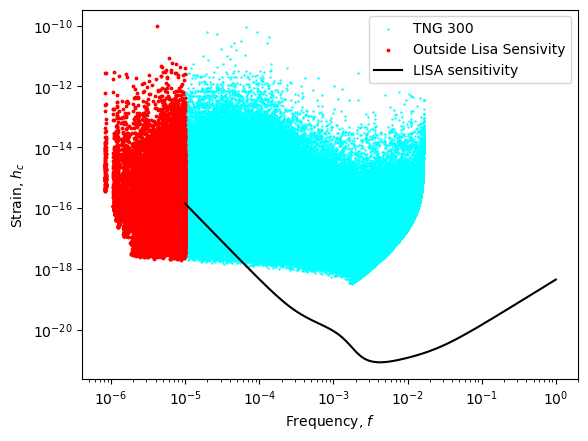

In [13]:
###LISA Sensitivity
merger_file="blackhole_mergers_tng300.hdf5"
merger_data=h5py.File(merger_file, 'r')
M_1=np.maximum(merger_data['mass_out'],merger_data['mass_in'])*1e10/.6774
M_2=np.minimum(merger_data['mass_out'],merger_data['mass_in'])*1e10/.6774
z=np.array(merger_data['time'])**(-1)-1

f_c, h_c, mu=gw_calc(M_1,M_2,z)
snr=snr_calc(f_c, h_c)


Mask=((np.min(lisa_f)<f_c) & (np.max(lisa_f)>f_c))
mask_outside=((np.min(lisa_f)>f_c) | (np.max(lisa_f)<f_c))
#mask_undetected=((np.min(lisa_h)>h_c) | (np.max(lisa_h)<h_c))
plt.scatter(f_c,h_c,label='TNG 300', c='cyan',marker='.', s=2)
plt.scatter(f_c[mask_outside],h_c[mask_outside], label='Outside Lisa Sensivity', c='red',s=3)
#plt.scatter(f_c[mask_undetected],h_c[mask_undetected], label='Outside Lisa Sensivity', c='blue',s=3)
plt.plot(lisa_f, lisa_h, label='LISA sensitivity',c='black')

plt.xlabel('Frequency, $f$')
plt.ylabel('Strain, $h_c$')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper right')

plt.savefig('LLISA Sensitivity',dpi=300)
plt.show()

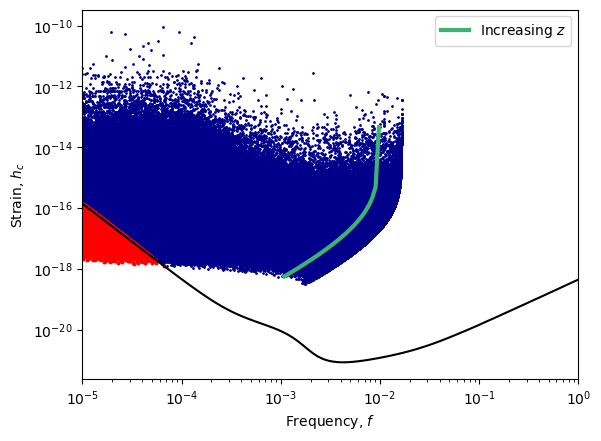

In [14]:
z_list=np.linspace(.001, 8.001, 100)

h_1=[]
f_1=[]
for i in range(len(z_list)):
    f1, h1, mu1 = gw_calc(10**6.3, 10**6.3, z=z_list[i])
    h_1.append(h1)
    f_1.append(f1)
plt.plot(f_1,h_1, label='Increasing $z$', c='mediumseagreen',linewidth=3)

plt.scatter(f_c,h_c, c='darkblue',marker='.', s=4)
plt.scatter(f_c[snr<1],h_c[snr<1],c='red',s=3)
plt.plot(lisa_f, lisa_h,c='black')

plt.xlabel('Frequency, $f$')
plt.ylabel('Strain, $h_c$')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper right')
plt.xlim(np.min(lisa_f),np.max(lisa_f))

plt.savefig('LISA with increasing z',dpi=300)

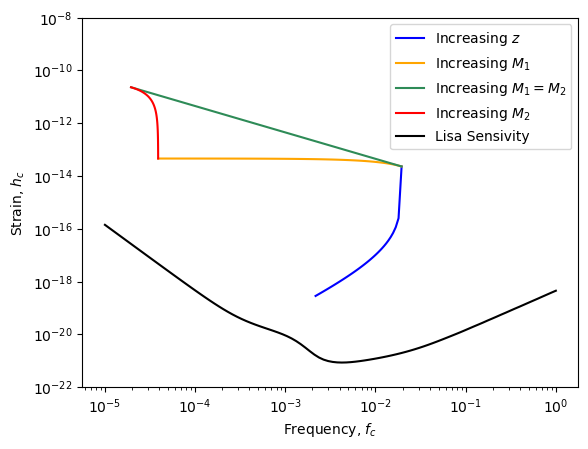

In [15]:
z_list=np.linspace(.001, 8.001, 100)

Mass_list=np.logspace(np.log10(1e6), np.log10(1e9), 100)
#curve1
h_1=[]
f_1=[]
for i in range(len(z_list)):
    f1, h1, mu1 = gw_calc(1e6, 1e6, z=z_list[i])
    h_1.append(h1)
    f_1.append(f1)
   
  
plt.plot(f_1,h_1, label='Increasing $z$', c='b')
#curve2
h_2=[]
f_2=[]
for i in range(len(Mass_list)):
    f2, h2, mu2 = gw_calc(Mass_list[i], 1e6,z=z_list[0])
    h_2.append(h2)
    f_2.append(f2)
plt.plot(f_2,h_2, label='Increasing $M_1$',c='orange')

#curve3
h_3=[]
f_3=[]
for i in range(len(Mass_list)):
    f3, h3, mu3 = gw_calc(Mass_list[i],Mass_list[i],z=z_list[0])
    h_3.append(h3)
    f_3.append(f3)
plt.plot(f_3, h_3, label='Increasing $M_1 = M_2$',c='seagreen')
#curve4
h_4=[]
f_4=[]
for i in range(len(Mass_list)):
    f4, h4, mu4 = gw_calc(1e9,Mass_list[i], z=z_list[0])
    h_4.append(h4)
    f_4.append(f4)
plt.plot(f_4, h_4,  label='Increasing $M_2$',c='r')


plt.plot(lisa_f,lisa_h,c='black',label='Lisa Sensivity')
plt.ylim(10**(-22),10**(-8))
#plt.xlim(left=10**(-6))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency, $f_c$')
plt.ylabel('Strain, $h_c$')
plt.legend(loc='upper right')
plt.savefig('Changing_parameters.png',dpi=300)
plt.show()


In [16]:
def z_snr_m(z_i=.001, z_f=8.001, num=100,m_1=1e6,m_2=1e6):
    z_list=np.linspace(z_i, z_f, num)
    h_1=[]
    f_1=[]
    for i in range(len(z_list)):
        f1, h1, mu1 = gw_calc(m_1, m_2, z=z_list[i])
        h_1.append(h1)
        f_1.append(f1)
    snr_z=snr_calc(f_1,h_1)
    return z_list, snr_z

In [17]:
tmpval=0.0001
print('z='+str(tmpval))

z=0.0001


In [18]:
def  m_snr_z(z=0.0001,m_i=1e6,m_f=1e9, title=None):

    Mass_list=np.logspace(np.log10(m_i), np.log10(m_f), 100)
    h_2=[]
    f_2=[]
    for i in range(len(Mass_list)):
        f2, h2, mu2 = gw_calc(Mass_list[i], m_i,z=z)
        h_2.append(h2)
        f_2.append(f2)

    h_3=[]
    f_3=[]
    for i in range(len(Mass_list)):
        f3, h3, mu3 = gw_calc(Mass_list[i],Mass_list[i],z=z)
        h_3.append(h3)
        f_3.append(f3)

    h_4=[]
    f_4=[]
    for i in range(len(Mass_list)):
        f4, h4, mu4 = gw_calc(m_f,Mass_list[i], z=z)
        h_4.append(h4)
        f_4.append(f4)


    snr_M1=snr_calc(f_2,h_2)
    snr_same=snr_calc(f_3,h_3)
    snr_M2=snr_calc(f_4,h_4)

    plt.plot(Mass_list,snr_M1, label='Changing M$_1$',c='orange')
    plt.plot(Mass_list,snr_M2, label='Changing M$_2$', c='r' )
    plt.plot(Mass_list,snr_same, label='Same M$_1$ & M$_2$',c='seagreen')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$M_\odot$')
    plt.ylabel('$SNR$')
    if title == None:
        plt.title('z='+str(z))
    else:
        plt.title(title)
    plt.legend(loc='upper right')
    plt.grid(True, which="both", ls=":")
    plt.show()
    return


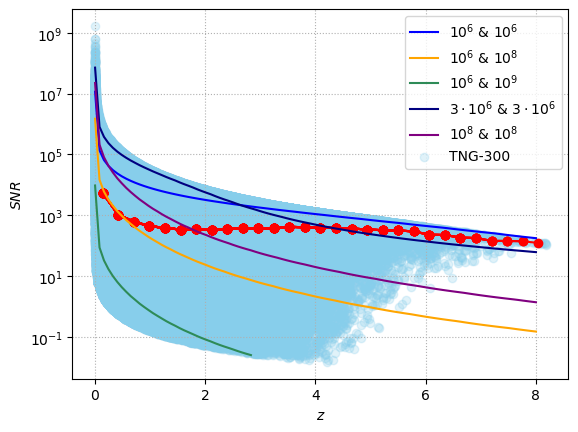

In [19]:
### z vs SNR
z_list, snr_0=z_snr_m()
z_list, snr_1=z_snr_m(m_1=1e8)
z_list, snr_2=z_snr_m(m_1=1e8,m_2=1e8)
z_list, snr_4=z_snr_m(m_1=3e6,m_2=3e6)
z_list, snr_3=z_snr_m(m_1=1e9)
avg_x, avg_y=x_mean_plotter(z, snr,xgmean=False,xbins=30)
#y_mean_plotter(z, snr,xgmean=False)
plt.plot(z_list,snr_0, label='$10^{6}$ & $10^{6}$',c='blue')
plt.plot(z_list,snr_1, label='$10^{6}$ & $10^{8}$',c='orange')
plt.plot(z_list,snr_3, label='$10^{6}$ & $10^{9}$',c='seagreen')
plt.plot(z_list,snr_4, label='$3 \cdot 10^{6}$ & $3 \cdot 10^{6}$',c='navy')
plt.plot(z_list,snr_2, label='$10^{8}$ & $10^{8}$',c='purple')

plt.scatter(z, snr, c='skyblue',label='TNG-300',alpha=.25)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('$z$')
plt.ylabel('$SNR$')
plt.legend(loc='upper right')
plt.grid(True, which="both", ls=":")
plt.savefig('zvsnr.png', dpi=300)
plt.show()
   


C:\Users\karma\AppData\Local\Temp\ipykernel_27200\756386748.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10**11)


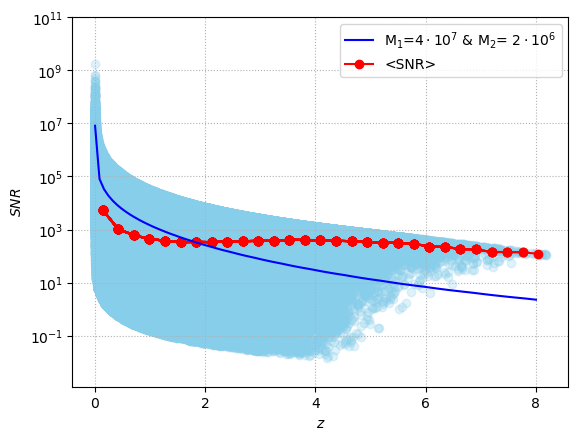

In [20]:
### z vs SNR
z_list, snr_0=z_snr_m()
#z_list, snr_1=z_snr_m(m_1=1e8)
z_list, snr_2=z_snr_m(m_1=gmean(M_1),m_2=gmean(M_2))
#z_list, snr_4=z_snr_m(m_1=3e6,m_2=3e6)
#z_list, snr_3=z_snr_m(m_1=1e9)
avg_x, avg_y=x_mean_plotter(z, snr,xgmean=False,xbins=30,label='<SNR>')
#y_mean_plotter(z, snr,xgmean=False)
#plt.plot(z_list,snr_0, label='$10^{6}$ & $10^{6}$',c='blue')
#plt.plot(z_list,snr_3, label='$10^{6}$ & $10^{9}$',c='seagreen')
#plt.plot(z_list,snr_4, label='$3 \cdot 10^{6}$ & $3 \cdot 10^{6}$',c='navy')
plt.plot(z_list,snr_2, label='M$_1$=$4 \cdot 10^{7}$ & M$_2$= $2\cdot 10^{6}$',c='b')
plt.plot(1,10**20,label='<SNR>', marker='o',c='r')
plt.scatter(z, snr, c='skyblue',alpha=.25)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('$z$')
plt.ylim(0,10**11)
plt.ylabel('$SNR$')
plt.legend(loc='upper right')
plt.grid(True, which="both", ls=":")
plt.savefig('zvsnrforwith gmean.png', dpi=300)
plt.show()
   


In [21]:
print(gmean(M_1),gmean(M_2))

41286045.2862573 1971272.1948351786


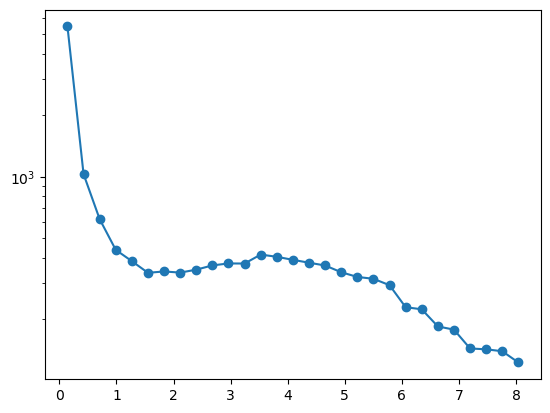

In [22]:
plt.plot(avg_x,avg_y,marker='o')
plt.yscale('log')

In [23]:
np.mean(snr[(z<=1)&(~np.isnan(snr))])

135064.79872749152

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\3604423494.py:1: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(Age, snr, alpha=.1, c= cmap(.95))


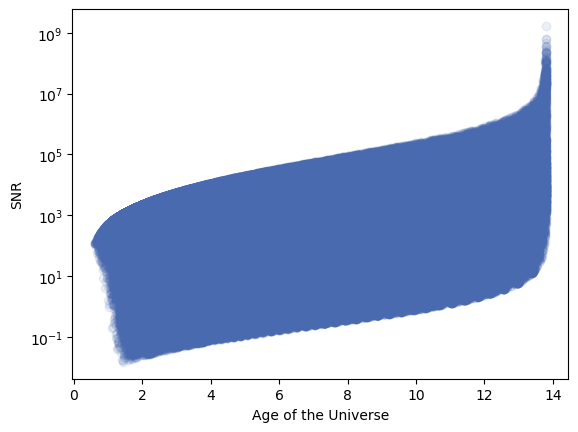

In [24]:
plt.scatter(Age, snr, alpha=.1, c= cmap(.95))
plt.xlabel('Age of the Universe')
plt.ylabel('SNR')
plt.yscale('log')


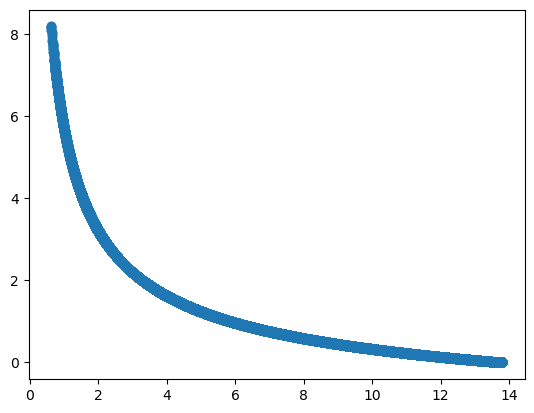

In [25]:
plt.scatter(Age, z)

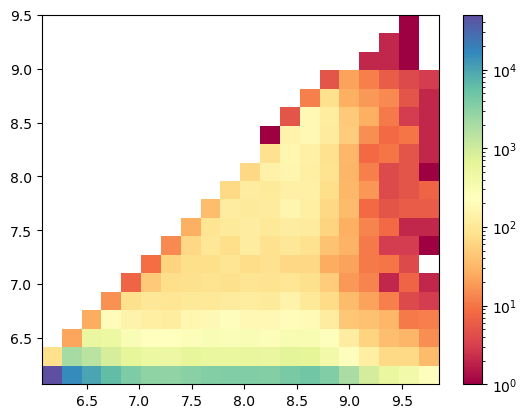

In [26]:
z_mask104=((z>=1.75)&(z<=4))
plt.hist2d(np.log10(M_1[z_mask104]),np.log10(M_2[z_mask104]), bins=20, density=False, cmap='Spectral',norm=matplotlib.colors.LogNorm())
plt.colorbar()

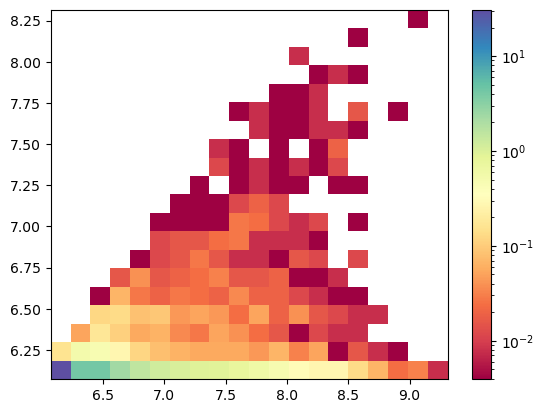

In [27]:
z_mask406=((z>=4)&(z<=6))
plt.hist2d(np.log10(M_1[z_mask406]),np.log10(M_2[z_mask406]), bins=20, density=True, cmap='Spectral',norm=matplotlib.colors.LogNorm())
plt.colorbar()

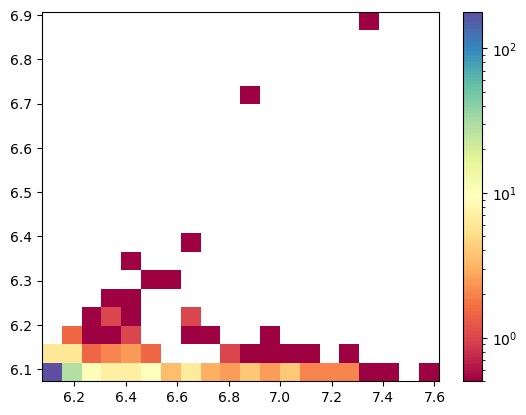

In [28]:
z_mask609=((z>=6)&(z<=9))
plt.hist2d(np.log10(M_1[z_mask609]),np.log10(M_2[z_mask609]), bins=20, density=True, cmap='Spectral',norm=matplotlib.colors.LogNorm())
plt.colorbar()

In [29]:
def avg_hist(x,y,z, bins=(20,20), c1='Spectral', c2= 'Spectral',  labelx=None, labely=None,
            labelz=None, norm1=matplotlib.colors.LogNorm(), logweight=True, 
            norm2=None, vmin=None,vmax=None):
 #            norm2=matplotlib.colors.LogNorm(vmin=None, vmax=None) ):
    z_mask=((~np.isnan(z))&(~np.isnan(x))&(~np.isnan(y)))
    x=x[z_mask]
    y=y[z_mask]
    z=z[z_mask]
    H_num, xedges, yedges = np.histogram2d(x, y, bins=bins)
    if logweight:
        z=np.log10(z)
    H_z, xedges, yedges = np.histogram2d(x,y, bins=(xedges, yedges), weights=z)
    H_num=H_num.T
    H_z=H_z.T
    plt.figure(figsize=(15,10))
    plt.subplot(2, 1, 1)
    plt.imshow(H_num, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
           cmap= c1, norm=norm1)
 
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.colorbar(label='Numbers')

    plt.subplot(2,1,2)
    plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
               cmap=c2, norm=norm2, vmax=vmax,vmin=vmin)
    #print(np.min(H_z/H_num), np.max(H_z/H_num))
    #print(H_z/H_num)
   
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.colorbar(label=labelz)
   
    
    plt.tight_layout()
    plt.gca().set_aspect('equal')

    

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


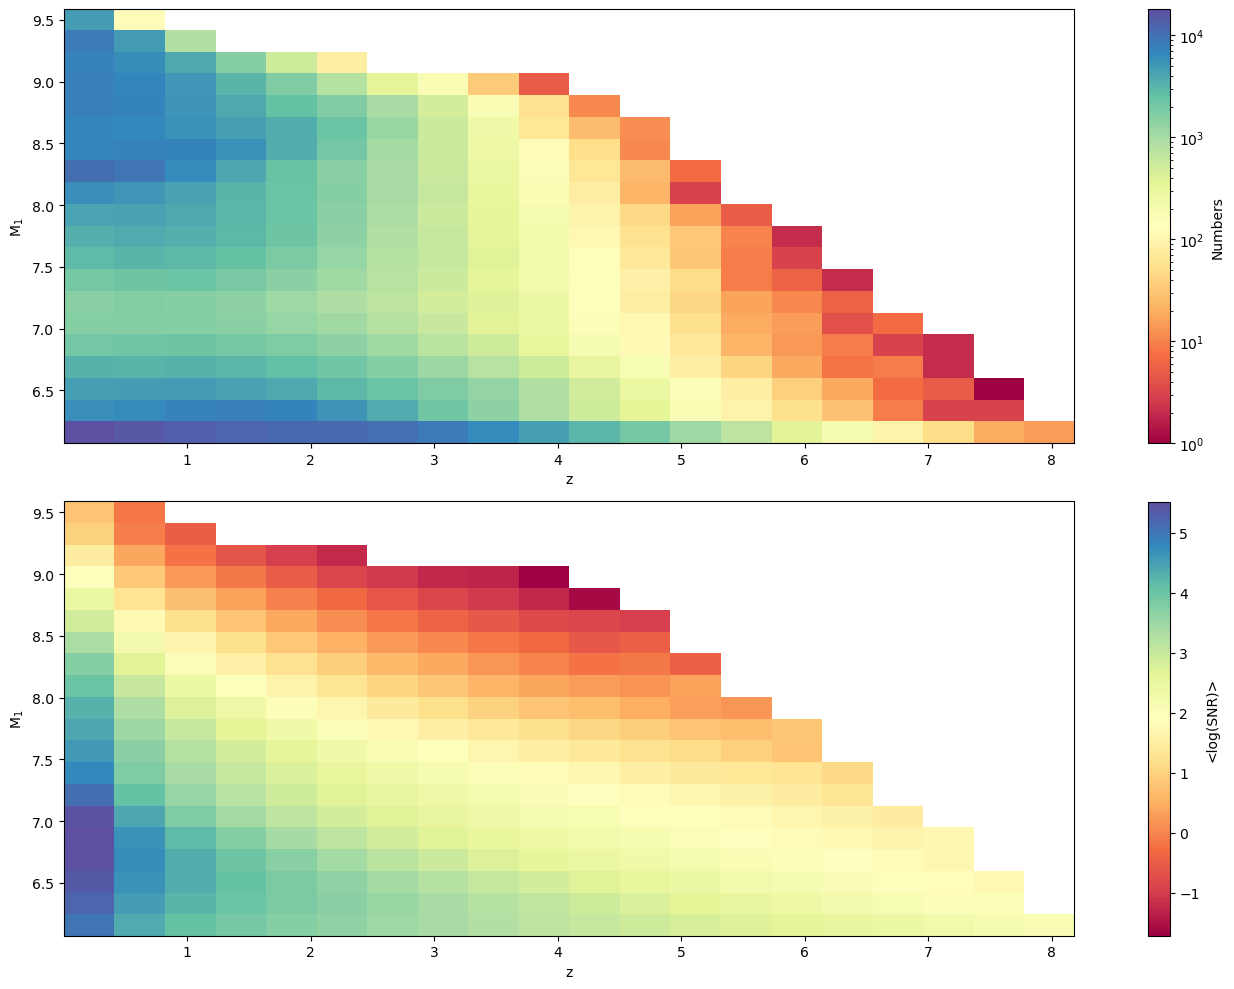

In [30]:

avg_hist(z, np.log10(M_1),snr, labelx='z',labely='M$_1$',labelz='<log(SNR)>')


In [31]:
print(len(M_1[z_mask406]))
print(len(M_1[z_mask104]))

14028
151930


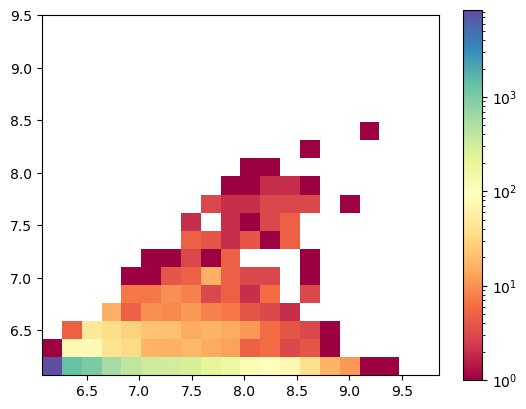

In [32]:
H_104, xedges, yedges = np.histogram2d(np.log10(M_1[z_mask104]), np.log10(M_2[z_mask104]), bins=(20,20))
H_406, xedges, yedges = np.histogram2d(np.log10(M_1[z_mask406]), np.log10(M_2[z_mask406]), bins=(xedges, yedges))
H_104=H_104.T
H_406=H_406.T

#Regular histogram:
plt.imshow(H_406, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
           cmap='Spectral', norm=matplotlib.colors.LogNorm())

plt.colorbar()

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\4058227113.py:1: RuntimeWarning: divide by zero encountered in divide
  temp_array=H_104/H_406*np.float(len(M_1[z_mask406]))/np.float(len(M_1[z_mask104]))
C:\Users\karma\AppData\Local\Temp\ipykernel_27200\4058227113.py:1: RuntimeWarning: invalid value encountered in divide
  temp_array=H_104/H_406*np.float(len(M_1[z_mask406]))/np.float(len(M_1[z_mask104]))
C:\Users\karma\AppData\Local\Temp\ipykernel_27200\4058227113.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  temp_array=H_104/H_406*np.float(len(M_1[z_mask406]))/np.float(len(M_1[z_mask104]))


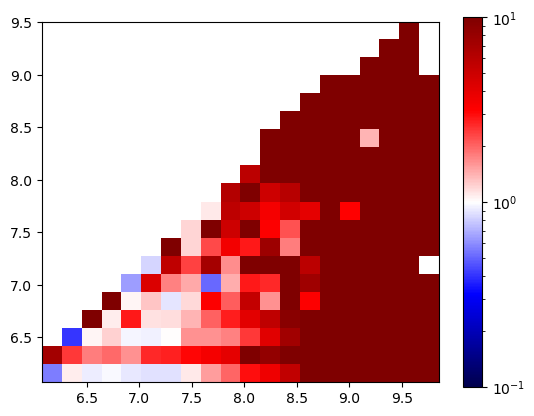

In [33]:
temp_array=H_104/H_406*np.float(len(M_1[z_mask406]))/np.float(len(M_1[z_mask104]))
temp_array[temp_array > 1e10]=10000


plt.imshow(temp_array, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='seismic',norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e1))
plt.colorbar()

c:\Users\karma\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\karma\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


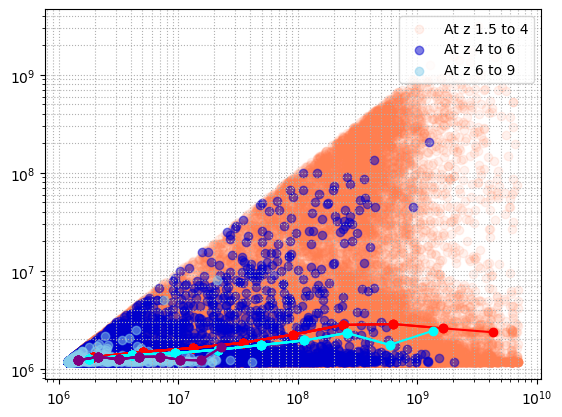

In [34]:
plt.grid(True, which="both", ls=":")
plt.scatter(M_1[z_mask104],M_2[z_mask104],alpha=.1, c='coral', label= 'At z 1.5 to 4')
x_mean_plotter(M_1[z_mask104],M_2[z_mask104])
plt.scatter(M_1[z_mask406],M_2[z_mask406],alpha=.5, color='mediumblue', label= 'At z 4 to 6')
x_mean_plotter(M_1[z_mask406],M_2[z_mask406], color='cyan')
plt.scatter(M_1[z_mask609],M_2[z_mask609], alpha=.5, color='skyblue',label= 'At z 6 to 9')
x_mean_plotter(M_1[z_mask609],M_2[z_mask609], color='purple')
plt.legend(loc='upper right')

plt.xscale('log')
plt.yscale('log')

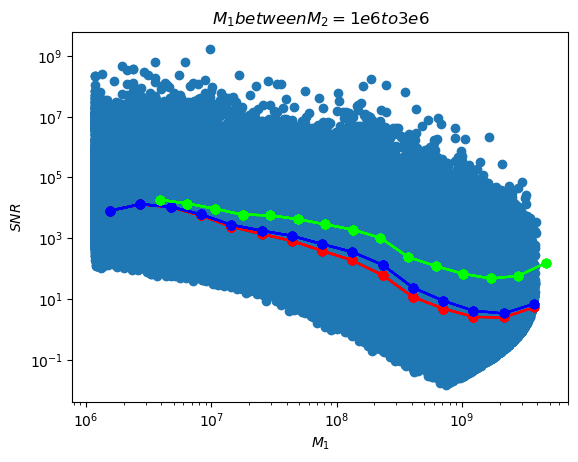

In [35]:
mask_M2=((M_2<3e6))
plt.scatter(M_1,snr)
x_mean_plotter(M_1[mask_M2],snr[mask_M2], xbins=20)
x_mean_plotter(M_1,snr, xbins=20, color= 'blue')
x_mean_plotter(M_1[M_2>3e6],snr[M_2>3e6], xbins=20, color='lime')

plt.title('$M_1 between M_2=1e6 to 3e6$')

plt.xlabel('$M_1$')
plt.ylabel('$SNR$')
plt.xscale('log')
plt.yscale('log')

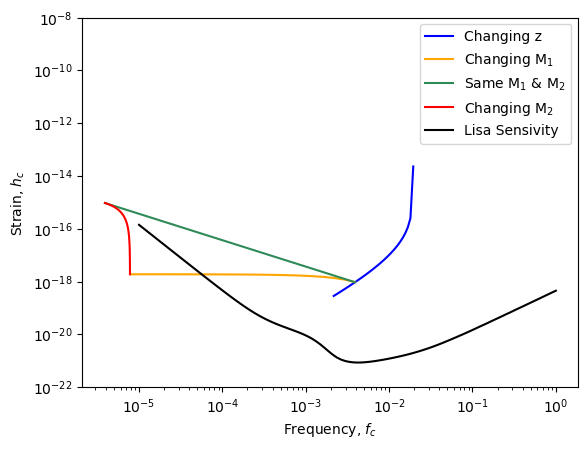

In [36]:
h_1=[]
f_1=[]
for i in range(len(z_list)):
    f1, h1, mu1 = gw_calc(1e6, 1e6, z=z_list[i])
    h_1.append(h1)
    f_1.append(f1)
   

z1=4
plt.plot(f_1,h_1, label='Changing z', c='b')
#curve2
h_2=[]
f_2=[]
for i in range(len(Mass_list)):
    f2, h2, mu2 = gw_calc(Mass_list[i], 1e6,z=z1)
    h_2.append(h2)
    f_2.append(f2)
plt.plot(f_2,h_2, label='Changing M$_1$',c='orange')

#curve3
h_3=[]
f_3=[]
for i in range(len(Mass_list)):
    f3, h3, mu3 = gw_calc(Mass_list[i],Mass_list[i],z=z1)
    h_3.append(h3)
    f_3.append(f3)
plt.plot(f_3, h_3, label='Same M$_1$ & M$_2$',c='seagreen')
#curve4
h_4=[]
f_4=[]
for i in range(len(Mass_list)):
    f4, h4, mu4 = gw_calc(1e9,Mass_list[i], z=z1)
    h_4.append(h4)
    f_4.append(f4)
plt.plot(f_4, h_4,  label='Changing M$_2$',c='r')



plt.plot(lisa_f,lisa_h,c='black',label='Lisa Sensivity')
plt.ylim(10**(-22),10**(-8))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency, $f_c$')
plt.ylabel('Strain, $h_c$')
plt.legend(loc='upper right')
plt.savefig("Changing_parameters_atz_4.png",dpi=300)



plt.show()


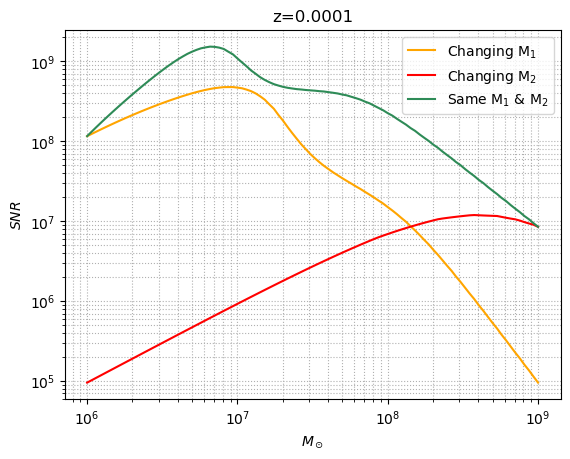

<Figure size 640x480 with 0 Axes>

In [37]:
m_snr_z()
plt.savefig('atz.0001.png',dpi=300)
plt.show()


C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


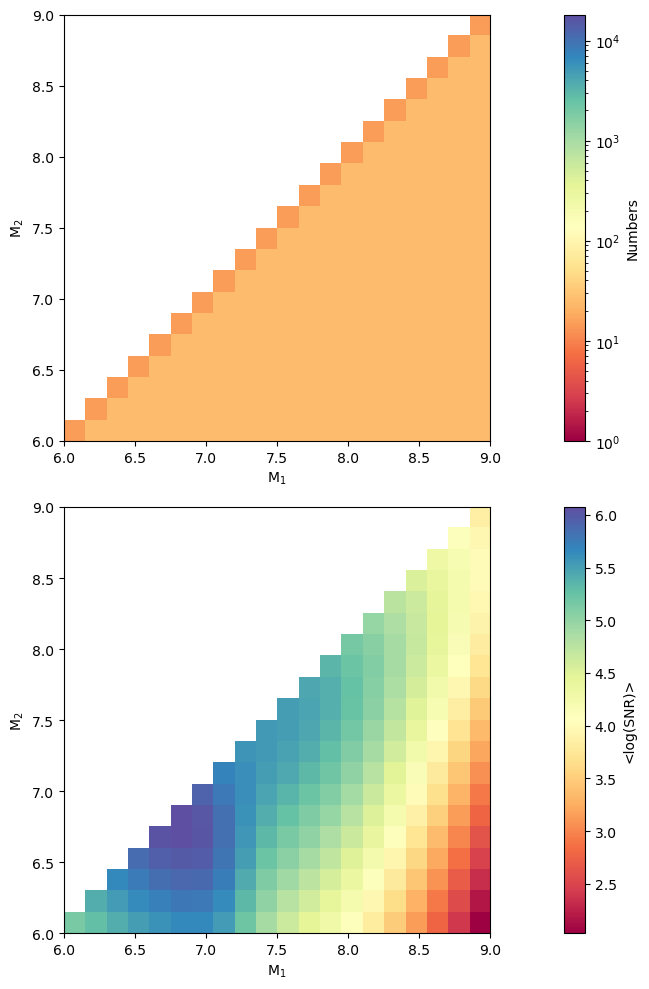

In [38]:
mass_list=np.linspace(6, 9, 100)
M1_list=[]
M2_list=[]
z_value=.1
for m1_counter in range(len(mass_list)):
    for m2_counter in range(m1_counter+1):
        M1_list.append(np.power(10,mass_list[m1_counter]))
        M2_list.append(np.power(10,mass_list[m2_counter]))
##z_list.append(z_value)
        #print(M1_list)
       # print(M2_list)
M1_list=np.array(M1_list)
M2_list=np.array(M2_list)
Z_list=np.ones(len(M1_list))*0+z_value
#plt.scatter(M1_list, M2_list)
#plt.xscale('log')
#plt.yscale('log')
#print(M1_list,M2_list, Z_list)
f_z, h_z, mu_z=gw_calc(M1_list,M2_list,z=Z_list)
snr_list=snr_calc(f_z,h_z)
#print(snr_list)
avg_hist(np.log10(M1_list),np.log10(M2_list),snr_list,labelx='M$_1$',labely='M$_2$', labelz='<log(SNR)>', bins=(20)
        )#,norm2=matplotlib.colors.LogNorm(vmax=1e6))



In [39]:
'$As it was a test every square has equal number of mergers but in the main diagonal ones there are just few less. The 2nd hist gram shows the mathematical relation between the entities as we can see gradual increase or no sudden ups and downs. but we can see that for redshift 1 we can see the stronger snr value comes from  with M1 and M2 of 1e6.5, on the other hand at .1 red shift the higher snr values comes from near 1e7 masses, but at high redshift the the mass range shifts to around 1e6 for the higher snr values  $'

'$As it was a test every square has equal number of mergers but in the main diagonal ones there are just few less. The 2nd hist gram shows the mathematical relation between the entities as we can see gradual increase or no sudden ups and downs. but we can see that for redshift 1 we can see the stronger snr value comes from  with M1 and M2 of 1e6.5, on the other hand at .1 red shift the higher snr values comes from near 1e7 masses, but at high redshift the the mass range shifts to around 1e6 for the higher snr values  $'

In [40]:
max(snr_list)

1216748.5427164112

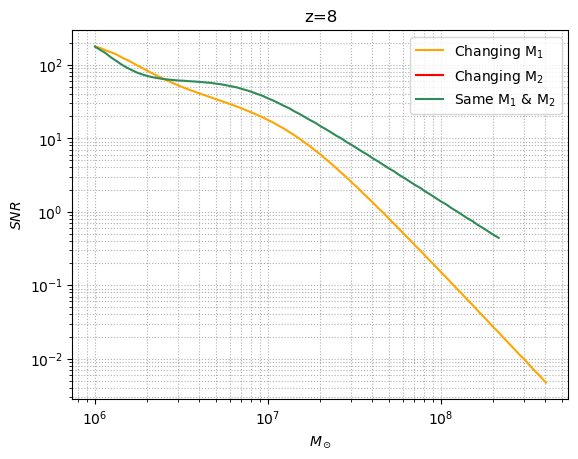

<Figure size 640x480 with 0 Axes>

In [41]:
m_snr_z(z=8,title='z=8')
plt.savefig('atz8.png',dpi=300)
plt.show()


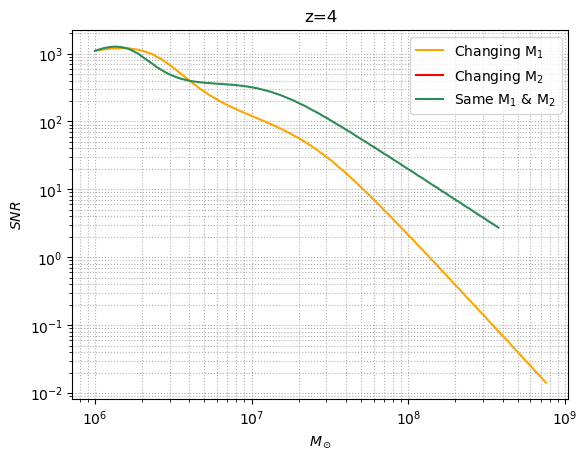

In [42]:
m_snr_z(z=4
       )

In [43]:
'$At higher redshift we can see at low M1 and M2 we get higher SNR values.As smaller Masses give higher snr values.$'

'$At higher redshift we can see at low M1 and M2 we get higher SNR values.As smaller Masses give higher snr values.$'

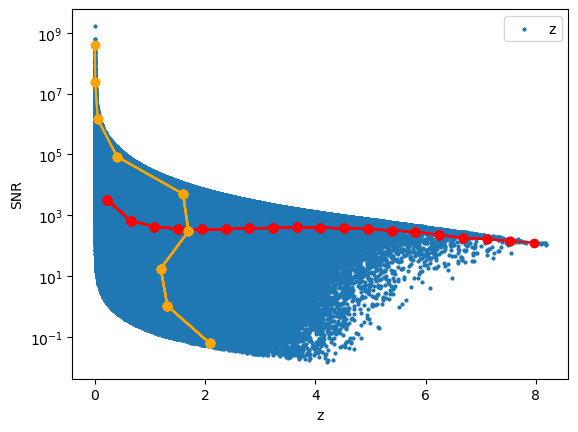

In [44]:
plt.scatter(z, snr, label='z', marker='o',s=4)
x_mean_plotter(z, snr,xgmean=False,xbins=20)
y_mean_plotter(z, snr,xgmean=False)

plt.xlabel('z')
plt.ylabel('SNR')
plt.yscale('log')
plt.savefig('tng50-snrVz.png',dpi=400)
plt.legend(loc='upper right')
plt.show()

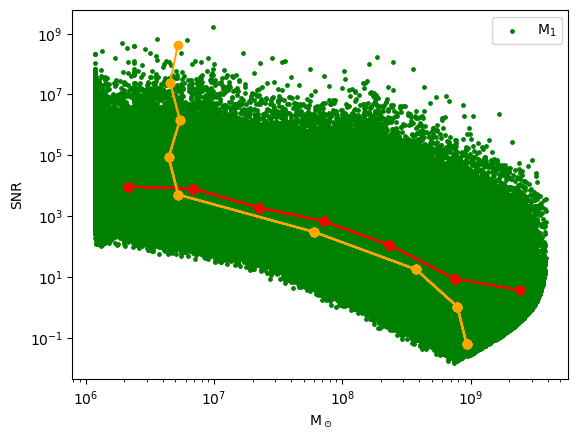

In [45]:
plt.scatter(M_1, snr, c='g', label='M$_1$', marker='o', s=6)
x_mean_plotter(M_1, snr)
y_mean_plotter(M_1, snr)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('M$_\odot$')
plt.ylabel('SNR')
plt.legend(loc='upper right')
plt.show()

In [46]:
'$there are vertical straght lines, at the begining when the simulation puts the the blackhole they merge with some the equal mass, and we can see the second vertical line for that. WE can see some vertical lines in the end of the simulation, which represent big blackholes, as after their mergers their mass does not change that much $' 

'$there are vertical straght lines, at the begining when the simulation puts the the blackhole they merge with some the equal mass, and we can see the second vertical line for that. WE can see some vertical lines in the end of the simulation, which represent big blackholes, as after their mergers their mass does not change that much $'

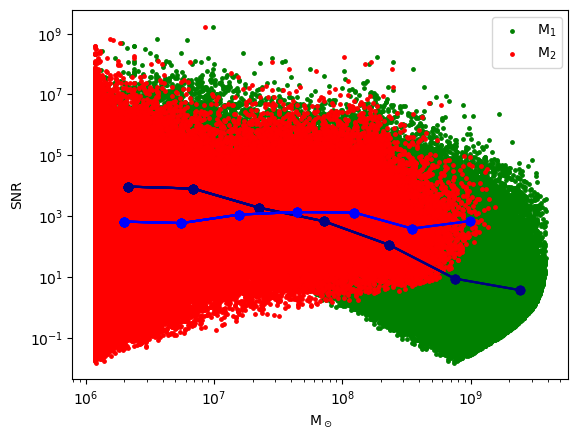

In [47]:

plt.scatter(M_1, snr, c='g', label='M$_1$', marker='o', s=6)
x_mean_plotter(M_1, snr,color='navy')

plt.scatter(M_2, snr, c='r', label='M$_2$', marker='o', s=6)
x_mean_plotter(M_2, snr,color='blue')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('M$_\odot$')
plt.ylabel('SNR')
plt.legend(loc='upper right')
plt.show()


In [48]:
'$We can see as the M1 increases average snr decreases but for the M2 it stays the same instead of decreaseing as those mergers happen at low redshift and with higher M1s $'

'$We can see as the M1 increases average snr decreases but for the M2 it stays the same instead of decreaseing as those mergers happen at low redshift and with higher M1s $'

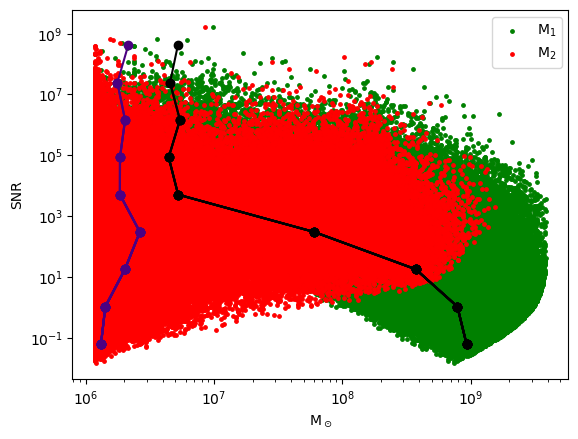

In [49]:
plt.scatter(M_1, snr, c='g', label='M$_1$', marker='o', s=6)
y_mean_plotter(M_1, snr,color='black')
plt.scatter(M_2, snr, c='r', label='M$_2$', marker='o', s=6)
y_mean_plotter(M_2, snr,color='indigo')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('M$_\odot$')
plt.ylabel('SNR')
plt.legend(loc='upper right')
plt.show()

In [50]:
'$there are vertical straght lines, at the begining when the simulation puts the the blackhole they merge with some the equal mass, and we can see the second vertical line for that$'

'$there are vertical straght lines, at the begining when the simulation puts the the blackhole they merge with some the equal mass, and we can see the second vertical line for that$'

In [51]:
'Average snr at any redshift is around 1e3'

'Average snr at any redshift is around 1e3'

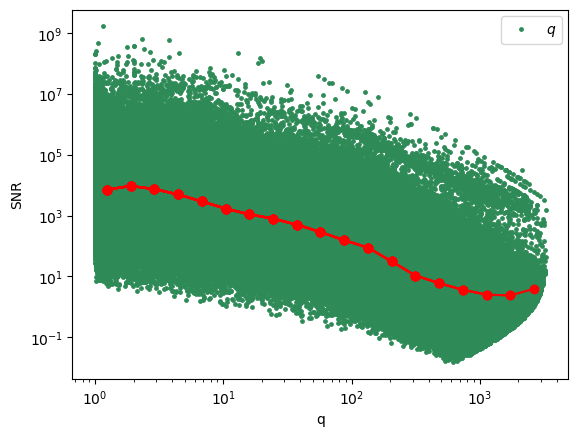

In [52]:
q=M_1/M_2
plt.scatter(q, snr, c='seagreen', label='$q$', marker='o', s=6)

x_mean_plotter(q[Mask], snr[Mask], xbins=20)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('q')
plt.ylabel('SNR')

plt.legend(loc='upper right')
plt.show()


In [53]:
#It lools similar to M1 vs SNR graph.Dont know why?



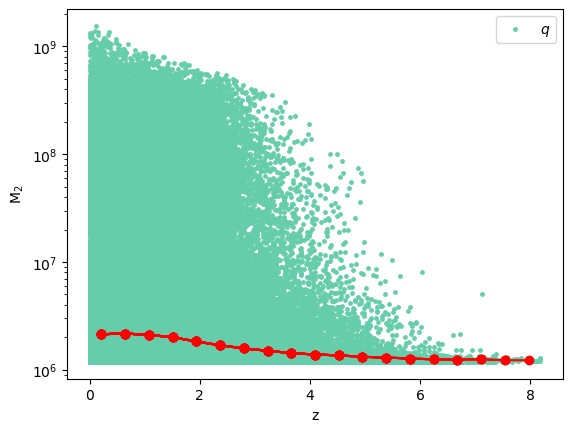

In [54]:
plt.scatter( z[Mask],M_2[Mask], c='mediumaquamarine', label='$q$', marker='o', s=6)
x_mean_plotter(z[Mask],M_2[Mask], xbins=20, xgmean=False)


plt.yscale('log')

plt.xlabel('z')
plt.ylabel('M$_2$')
plt.legend(loc='upper right')
plt.show()


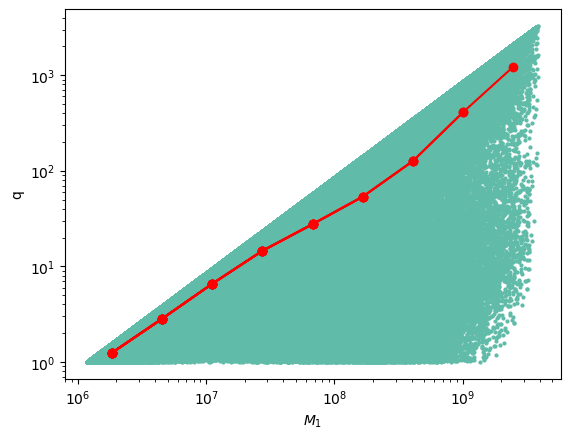

In [55]:
#plt.figure(figsize=[10,8])
plt.scatter(M_1[Mask],q[Mask], color=cmap(0.81), marker='o', s=4)
x_mean_plotter(M_1[Mask],q[Mask])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$M_1$')
plt.ylabel('q')
plt.savefig('test.png',dpi=400)

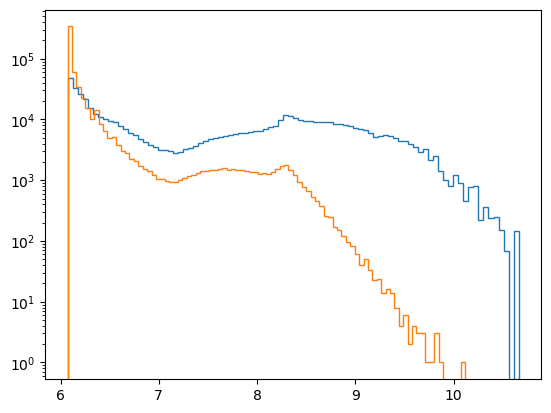

In [56]:
histdata =plt.hist(np.log10(M_1), bins=90, histtype='step', density=False)


#sns.kdeplot(np.log10(M_2),
#   fill=True, common_norm=False,
#   alpha=.5, linewidth=0)
histdata2 =plt.hist(np.log10(M_2), bins=90, histtype='step', density=False)
plt.yscale('log')
#plt.plot(histdata[1][1:21], histdata[0][0:20])

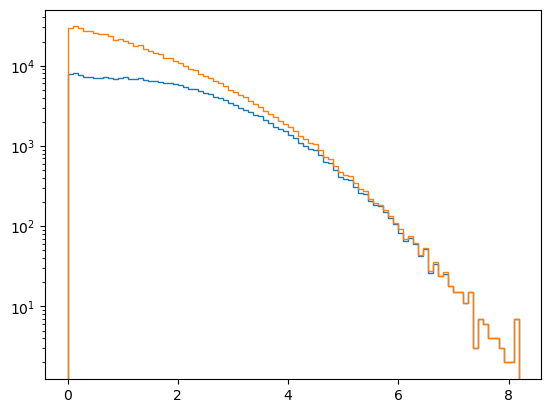

In [57]:
histdata =plt.hist(z[M_1 <1e7], bins=90, histtype='step', density=False)
histdata =plt.hist(z, bins=90, histtype='step', density=False)
plt.yscale('log')


<Axes: ylabel='Density'>

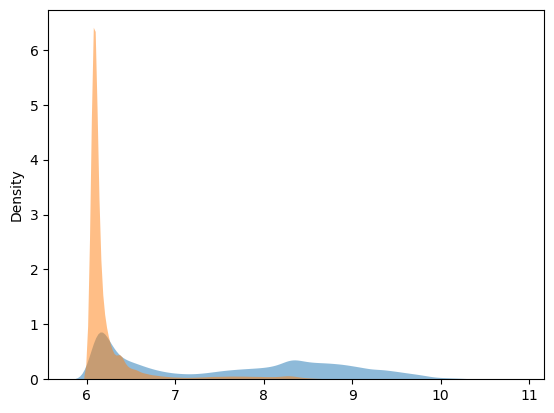

In [58]:
sns.kdeplot(np.log10(M_1),fill=True, common_norm=False,alpha=.5, linewidth=0)
sns.kdeplot(np.log10(M_2),fill=True, common_norm=False,alpha=.5, linewidth=0)


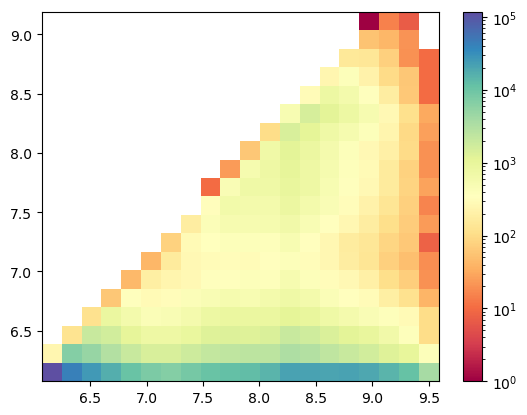

In [59]:
plt.hist2d(np.log10(M_1[Mask]),np.log10(M_2[Mask]), bins=20, density=False, cmap='Spectral',norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

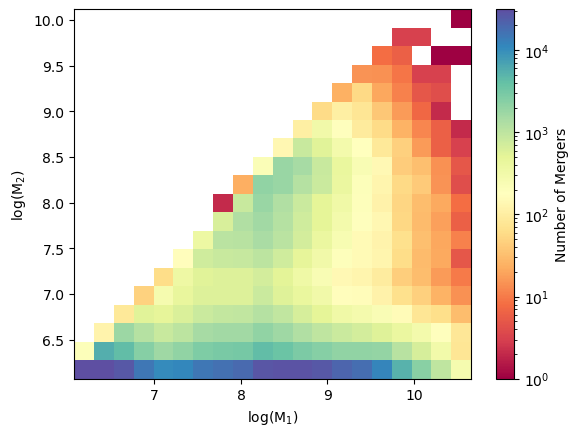

In [60]:
plt.hist2d(np.log10(M_1),np.log10(M_2), bins=20, density=False, cmap='Spectral',norm=matplotlib.colors.LogNorm(vmax=10**4.5))
plt.xlabel('log(M$_1$)')
plt.ylabel('log(M$_2$)')
plt.colorbar(label='Number of Mergers')
plt.savefig('avg_histM1_M2.png', dpi=300)

In [61]:
'$Most of the mergers have mass of  1e6 $'

'$Most of the mergers have mass of  1e6 $'

In [62]:
#sns.kdeplot(x=np.log10(M_1),y=np.log10(M_2), fill=True, color='green', cbar=True)

#plt.show()

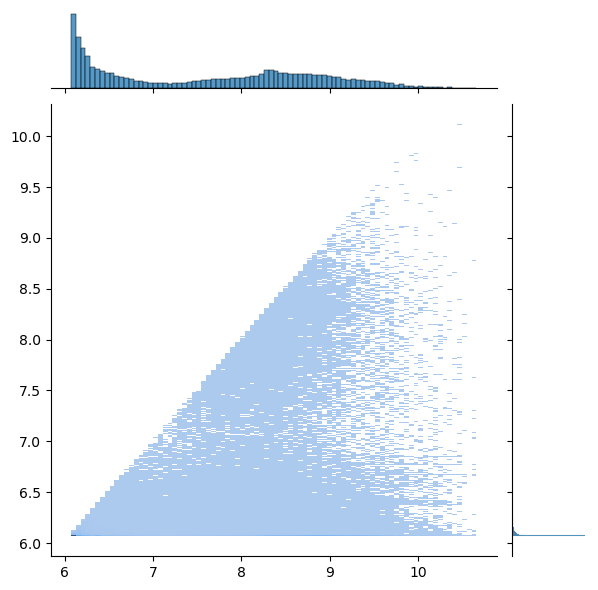

In [63]:

sns.jointplot(x=np.log10(M_1),y=np.log10(M_2), kind='hist')#,norm=matplotlib.colors.LogNorm())
#plt.colorbar()


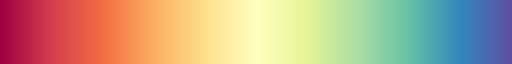

In [64]:
sns.color_palette("Spectral", as_cmap=True)

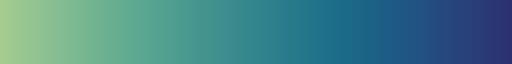

In [65]:
sns.color_palette("crest", as_cmap=True)

Text(0, 0.5, 'Number Of Mergers')

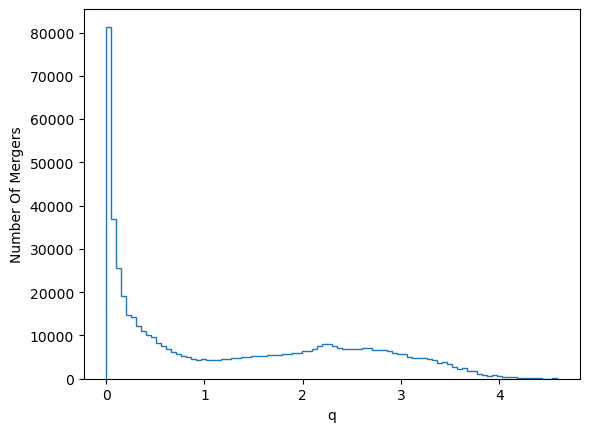

In [66]:
histdata =plt.hist(np.log10(q), bins=90, histtype='step', density=False)

plt.xlabel('q')
plt.ylabel('Number Of Mergers')

Text(0, 0.5, 'Number Of Mergers')

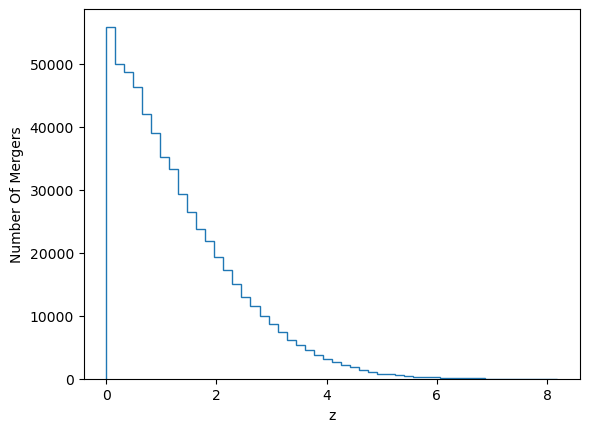

In [67]:
histdata =plt.hist(z, bins=50, histtype='step', density=False)
plt.xlabel('z')
plt.ylabel('Number Of Mergers')

In [68]:
'we can see that most blackhole mergers happened when the redshift is low, which is understandable as most of the blackholes are in low redshifts. '

'we can see that most blackhole mergers happened when the redshift is low, which is understandable as most of the blackholes are in low redshifts. '

<Axes: ylabel='Density'>

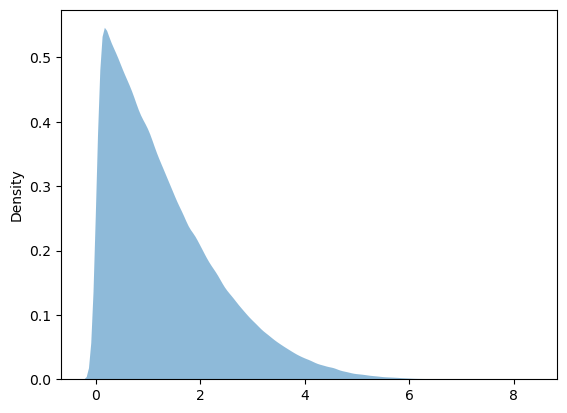

In [69]:
sns.kdeplot(z,fill=True, common_norm=False,
   alpha=.5, linewidth=0)

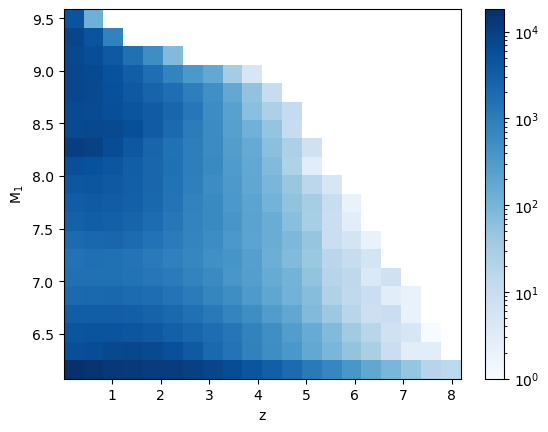

In [70]:
plt.hist2d(z[Mask],np.log10(M_1[Mask]), bins=20, density=False, cmap='Blues',norm=matplotlib.colors.LogNorm())
plt.xlabel('z')
plt.ylabel('M$_1$')
plt.colorbar()
plt.show()

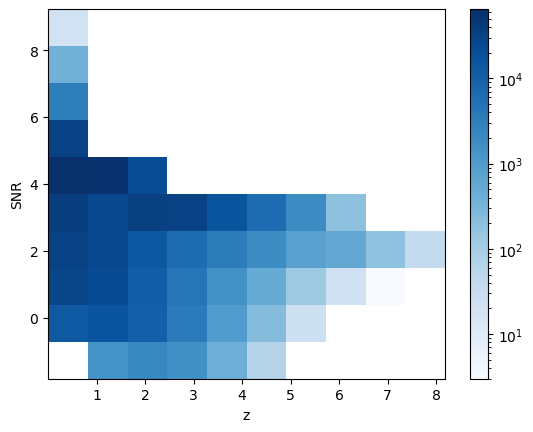

In [71]:
plt.hist2d(z[Mask],np.log10(snr[Mask]), bins=10, density=False, cmap='Blues',norm=matplotlib.colors.LogNorm())
plt.xlabel('z')
plt.ylabel('SNR')
plt.colorbar()
plt.show()

In [72]:
'At low redshift we can find most of the mergers and they have higher snr values'

'At low redshift we can find most of the mergers and they have higher snr values'

[2124312.1117427447, 6873301.713204885, 22238858.48957884, 71954767.52742521, 232812694.60624537, 753275323.2669668, 2437254178.0964117, 7885839008.884054, 25514965748.302643]


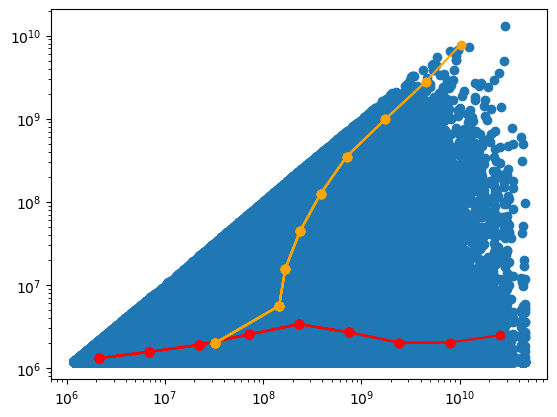

In [73]:
plt.scatter(M_1,M_2)
meanx, meany=x_mean_plotter(M_1,M_2)
y_mean_plotter(M_1,M_2)
plt.xscale('log')
plt.yscale('log')
print(meanx)

In [74]:
#np.save('snr_50.npy', snr_50)

##Later on:
#snr_50=np.load('snr_50.npy')

Text(0, 0.5, 'Number of Mergers')

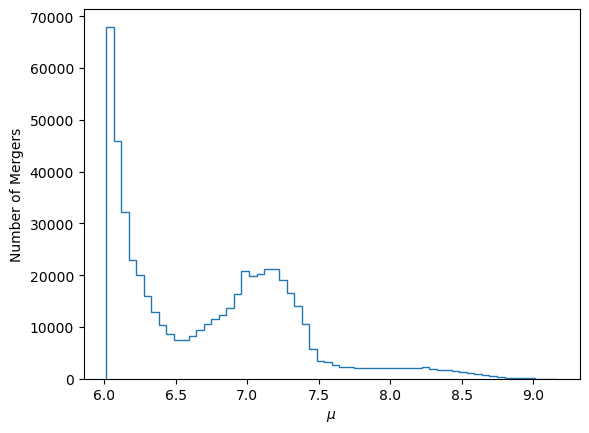

In [75]:
###mu_hist
histdata =plt.hist(np.log10(mu[Mask]), bins=60, histtype='step', density=False)
plt.xlabel('$\mu$')
plt.ylabel('Number of Mergers')


Text(0, 0.5, 'Number of Mergers')

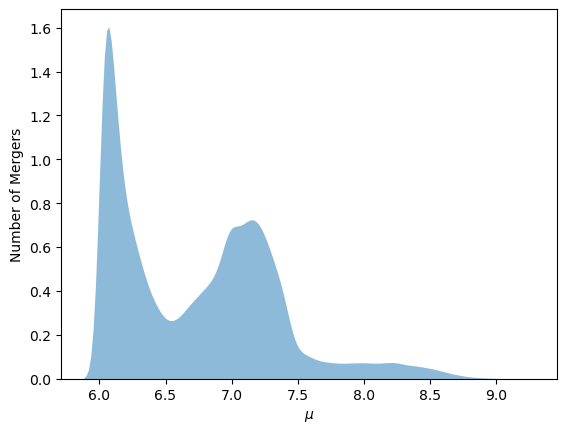

In [76]:
sns.kdeplot(np.log10(mu[Mask]),fill=True, common_norm=False,alpha=.5, linewidth=0)
plt.xlabel('$\mu$')
plt.ylabel('Number of Mergers')

In [77]:
#mu=(M_1*M_2)**(3/5)/M**(1/5)

In [78]:
'we see a second spike as when mu is between 1e6.5 to 1e7.5 those belong to Larger M1 and Smaller M2'

'we see a second spike as when mu is between 1e6.5 to 1e7.5 those belong to Larger M1 and Smaller M2'

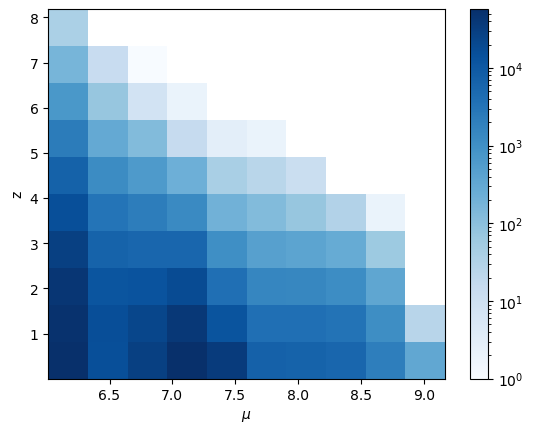

In [79]:
plt.hist2d(np.log10(mu[Mask]),z[Mask], bins=10, density=False, cmap='Blues',norm=matplotlib.colors.LogNorm())
plt.xlabel('$\mu$')
plt.ylabel('z')
plt.colorbar()
plt.show()

Text(0, 0.5, 'z')

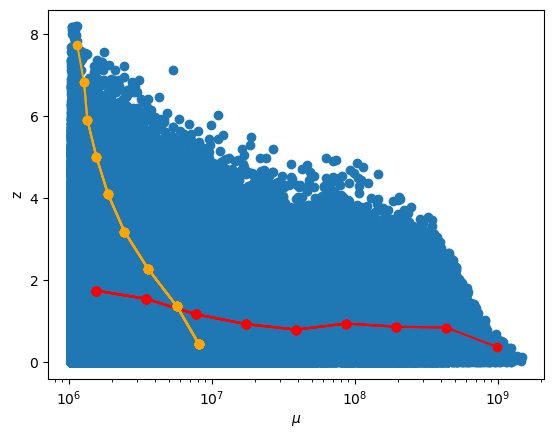

In [80]:
plt.scatter(mu[Mask], z[Mask])

x_mean_plotter(mu[Mask],z[Mask],ygmean=False)
y_mean_plotter(mu[Mask],z[Mask],ygmean=False)
plt.xscale('log')
plt.xlabel('$\mu$')
plt.ylabel('z')

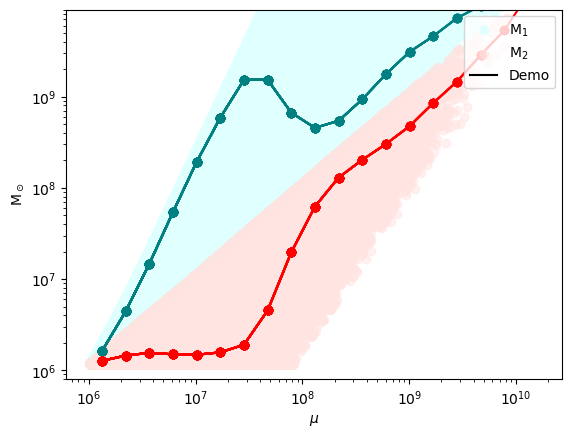

In [81]:
plt.scatter(mu,M_1, color='lightcyan',label='M$_1$')
x_mean_plotter(mu,M_1, color='teal', xbins=20)
plt.scatter(mu,M_2, alpha=.5, color='mistyrose',label='M$_2$')
x_mean_plotter(mu,M_2,xbins=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\mu$')
plt.ylabel('M$_\odot$')
plt.ylim(8e5,9e9)
plt.plot([1e6,1e7], [1e10,1e10], color='black', label='Demo')

plt.legend(loc='upper right')


c:\Users\karma\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\karma\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'SNR')

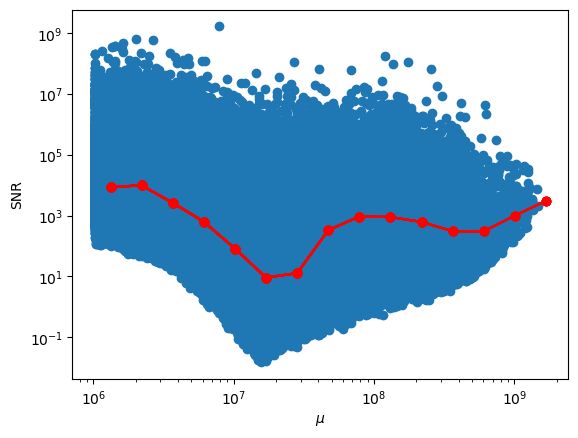

In [82]:
plt.scatter(mu,snr)
x_mean_plotter(mu,snr, xbins=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\mu$')
plt.ylabel('SNR')

In [83]:
'as between 1e6.5 and 1e7.5 M1 are much more larger than  the M2 they give smaller snr values thats why there is a dip in the averagre snr value'

'as between 1e6.5 and 1e7.5 M1 are much more larger than  the M2 they give smaller snr values thats why there is a dip in the averagre snr value'

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


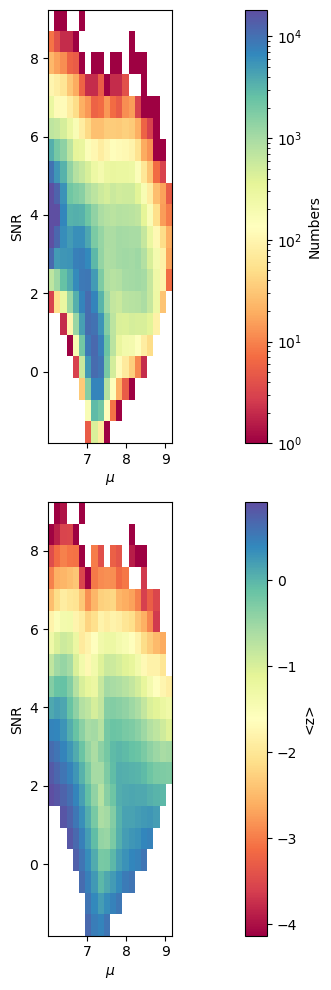

In [84]:
###avg_hist_mu_snr_z
avg_hist(np.log10(mu),np.log10(snr) ,z,norm2=None, labelx='$\mu$',labely='SNR',labelz='<z>')
plt.savefig('avg_hist_mu_snr_z.png',dpi=300)

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


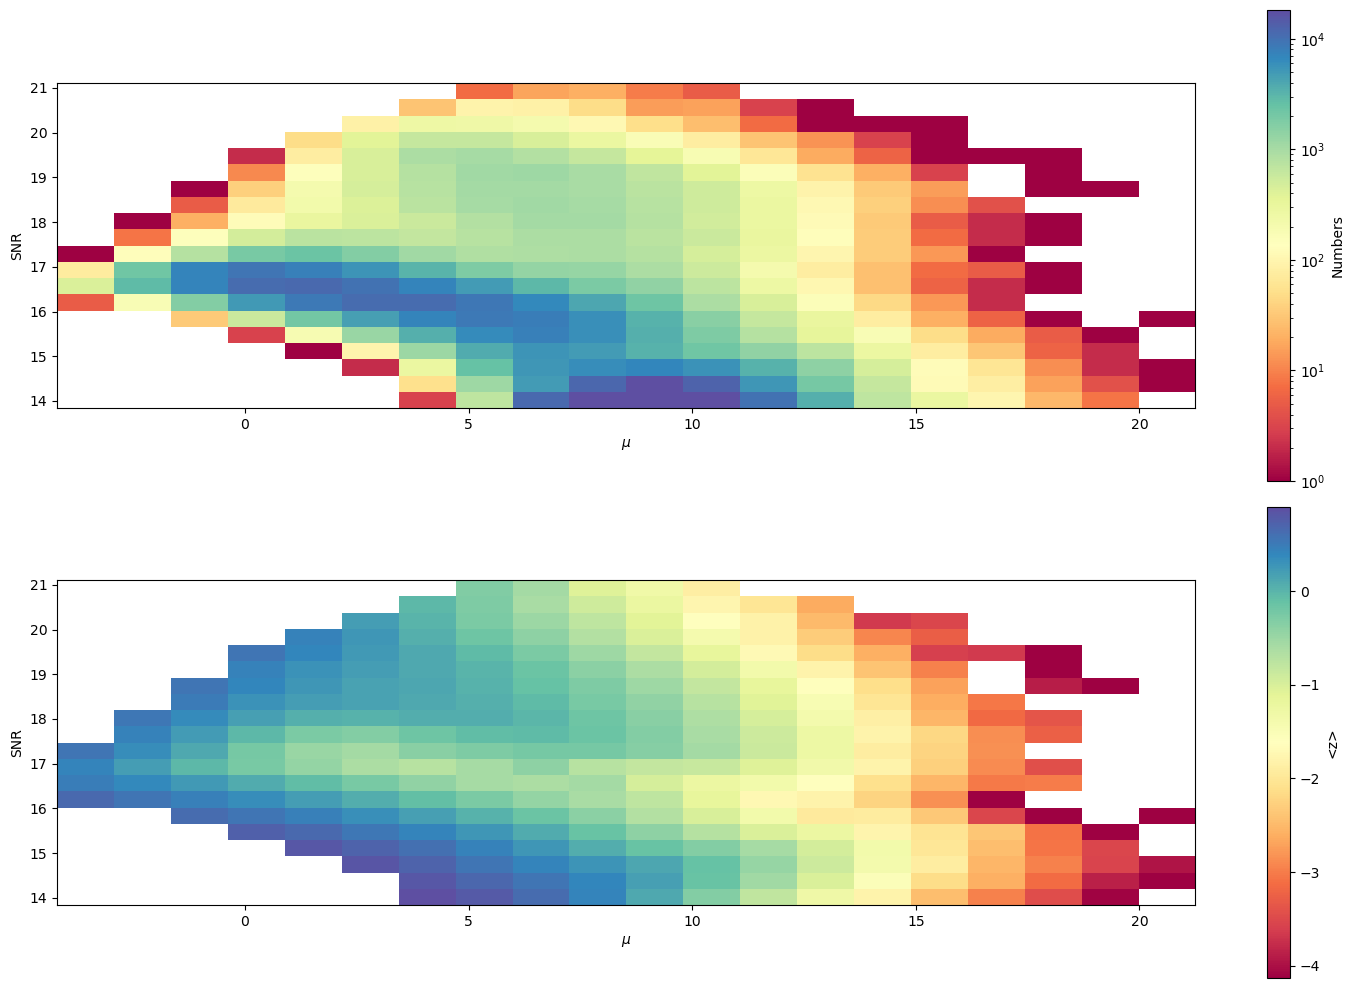

In [85]:

avg_hist(np.log(snr),np.log(mu) ,z,norm2=None, labelx='$\mu$',labely='SNR',labelz='<z>')


C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


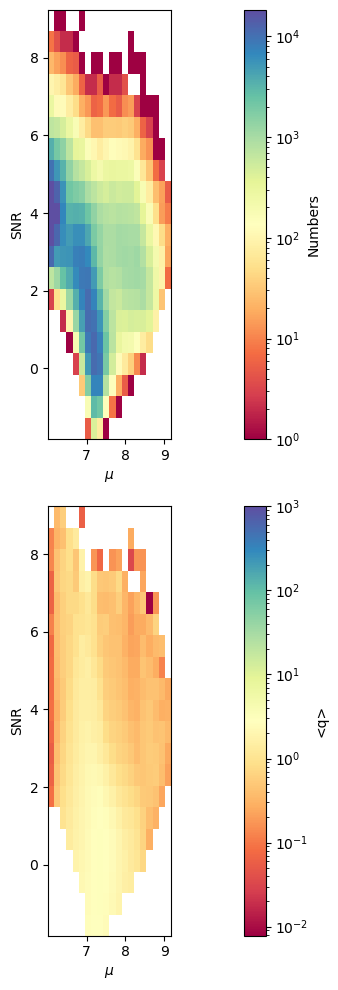

In [86]:
avg_hist(np.log10(mu),np.log10(snr) ,q,norm2=matplotlib.colors.LogNorm(vmax=1e3), labelx='$\mu$',labely='SNR',labelz='<q>')

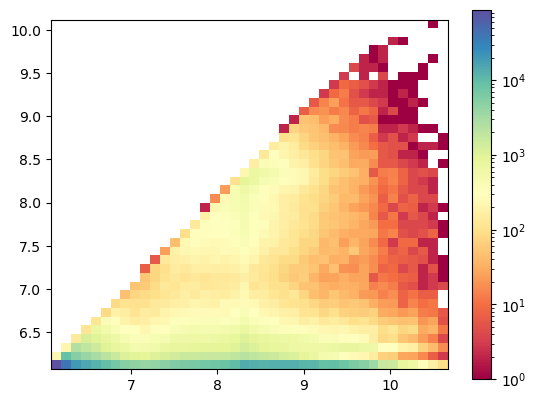

In [87]:
#plt.figure(figsize=(9,15))
#Histogram averaging for SNR
H_num, xedges, yedges = np.histogram2d(np.log10(M_1), np.log10(M_2), bins=(40,40))
H_z, xedges, yedges = np.histogram2d(np.log10(M_1), np.log10(M_2), bins=(xedges, yedges), weights=z)
H_num=H_num.T
H_z=H_z.T

#Regular histogram:
plt.imshow(H_num, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
           cmap='Spectral', norm=matplotlib.colors.LogNorm())
#Weighted histogram
#plt.imshow(H_snr/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
#plt.xscale('log')
#plt.yscale('log')
plt.colorbar()

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\2131036693.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Spectral', vmin=0,  vmax=1.75)#,norm=matplotlib.colors.LogNorm())


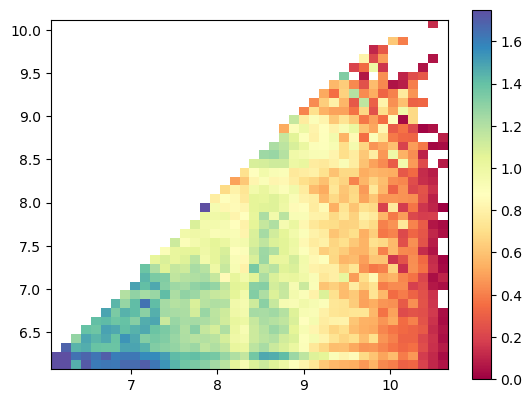

In [88]:
plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Spectral', vmin=0,  vmax=1.75)#,norm=matplotlib.colors.LogNorm())
plt.colorbar()

In [89]:
#M_1 Vs z average snr

In [90]:
#M_2 Vs z
#M_1 Vs m_2
#z v mu

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


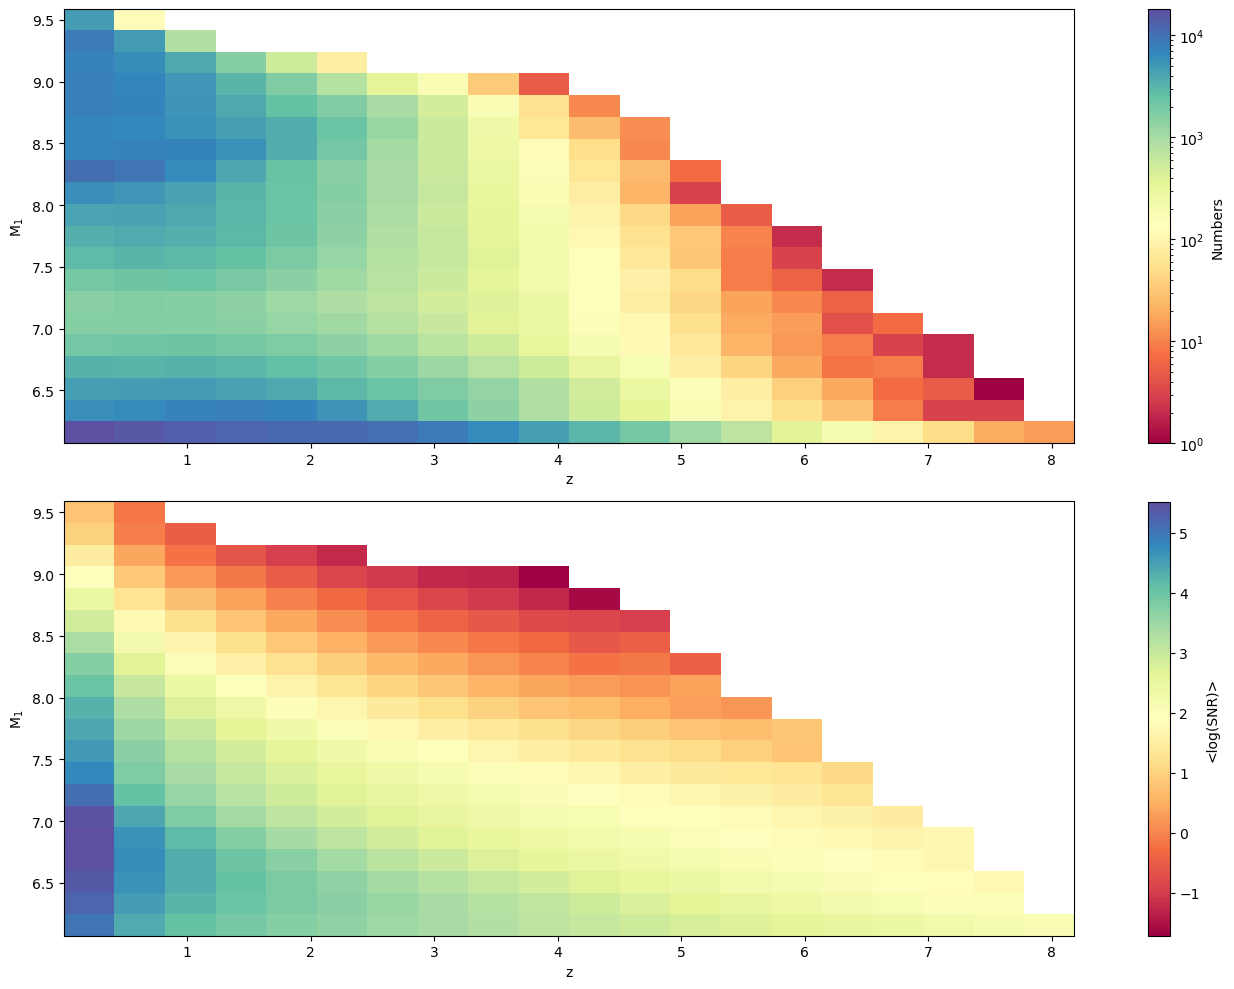

In [91]:
### avg _hist z_ M1_snr 
avg_hist(z, np.log10(M_1),snr, labelx='z',labely='M$_1$',labelz='<log(SNR)>')
plt.savefig('avg_histz_M1_snr.png', dpi=300)

In [92]:
'$1st Histogram shows that the number mergers happened at earlier redshift is way large than at higher redshift for amny M_1. The M_1s with mass of less than 1e6.5 are very common at low redshift. we can see the gradual increase in color for any mass from low red shift to high redshift.$'

'$1st Histogram shows that the number mergers happened at earlier redshift is way large than at higher redshift for amny M_1. The M_1s with mass of less than 1e6.5 are very common at low redshift. we can see the gradual increase in color for any mass from low red shift to high redshift.$'

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


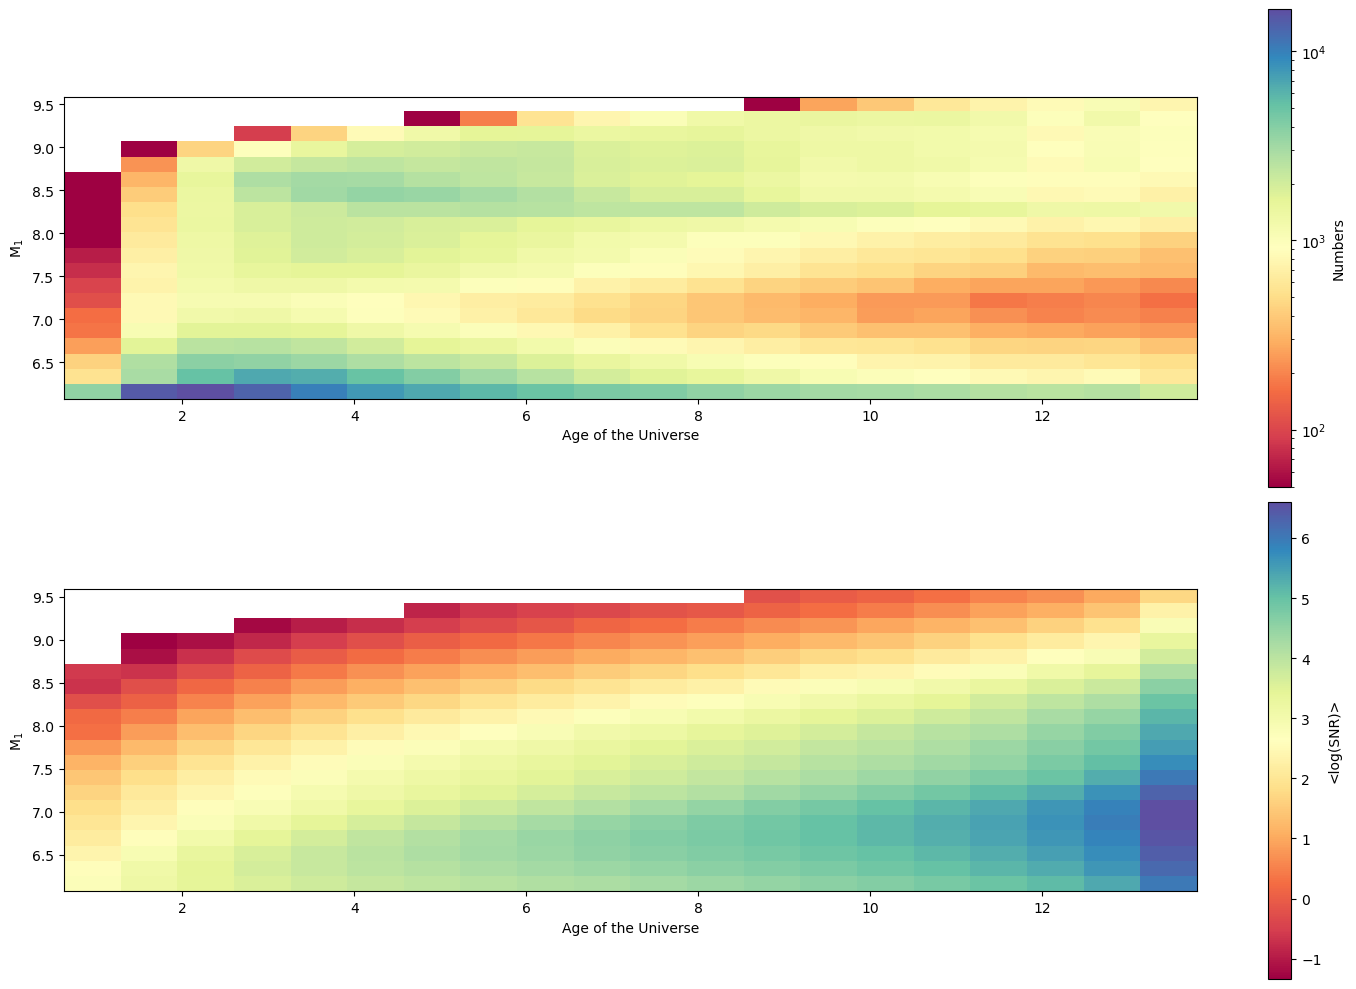

In [93]:

avg_hist(Age, np.log10(M_1),snr, norm1=matplotlib.colors.LogNorm(vmin=50),labelx='Age of the Universe',labely='M$_1$',labelz='<log(SNR)>')


In [94]:
'$ A significant number of mergers happeneded when the unversere age was 2 billon years old. We can also see a modal decrease from age 6-12billion years, which we can see also in red shift vs M_1 histogram.  $'

'$ A significant number of mergers happeneded when the unversere age was 2 billon years old. We can also see a modal decrease from age 6-12billion years, which we can see also in red shift vs M_1 histogram.  $'

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


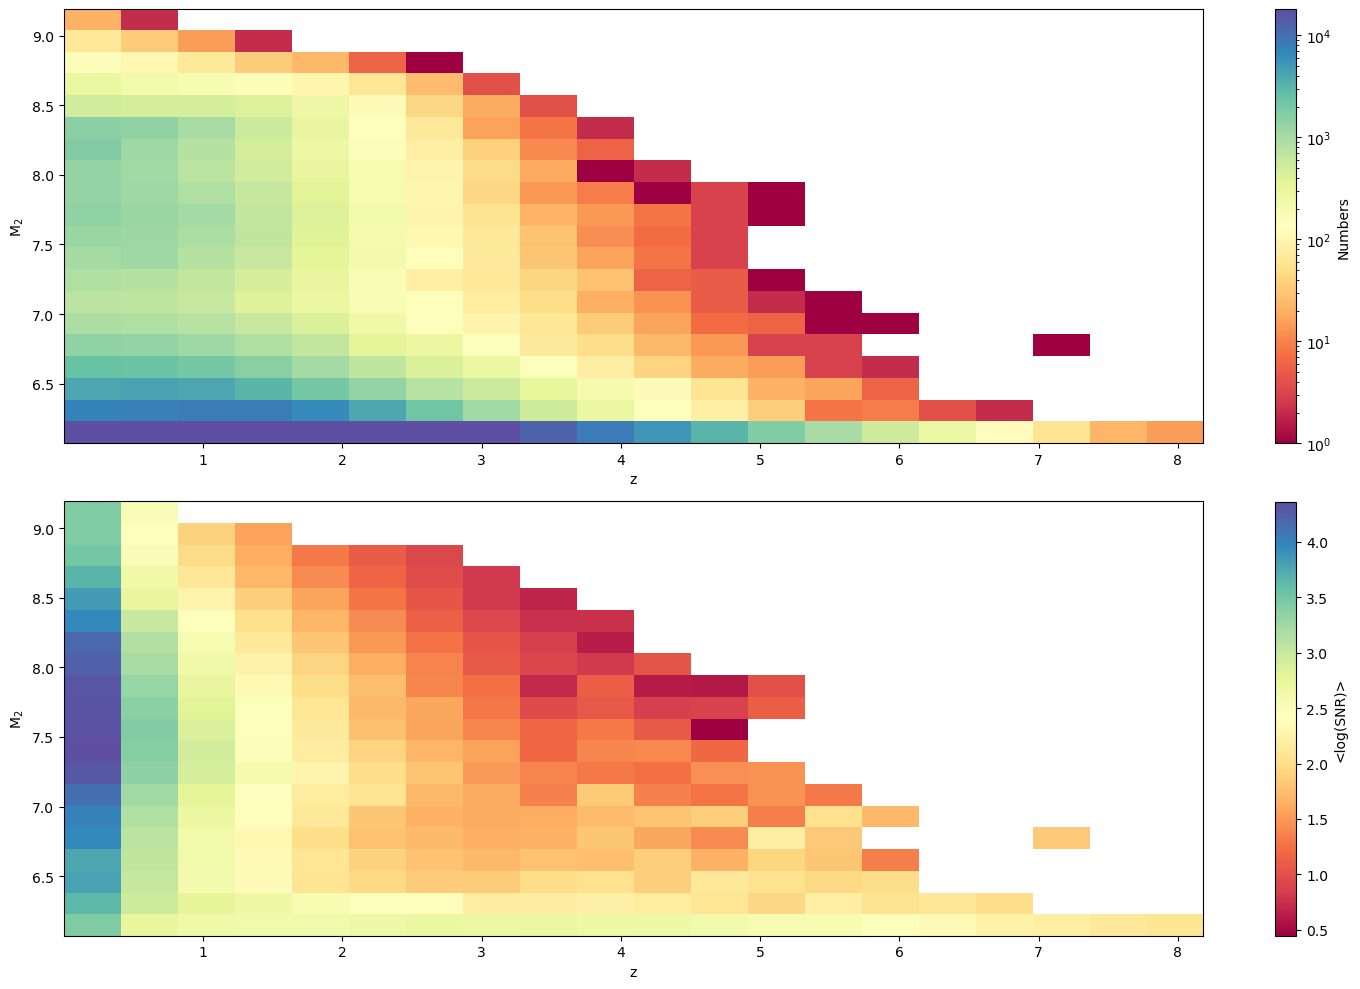

In [95]:
### avg _hist z_ M2_snr 
avg_hist(z, np.log10(M_2),snr, labelx='z',labely='M$_2$',labelz='<log(SNR)>')
plt.savefig('avg_histz_M2_snr.png', dpi=300)

In [96]:
np.mean(snr[((z<3)&(M_1>=10**6.6)&(M_1<=10**7.3))])

231993.21153420565

In [97]:
' as we know black holes with mass around 1e7 have high growth rate than any other mass range of blackholes so we dont see enough blackholes on that range , if we go higher or lower on the mass range we can find more common blackholes'

' as we know black holes with mass around 1e7 have high growth rate than any other mass range of blackholes so we dont see enough blackholes on that range , if we go higher or lower on the mass range we can find more common blackholes'

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


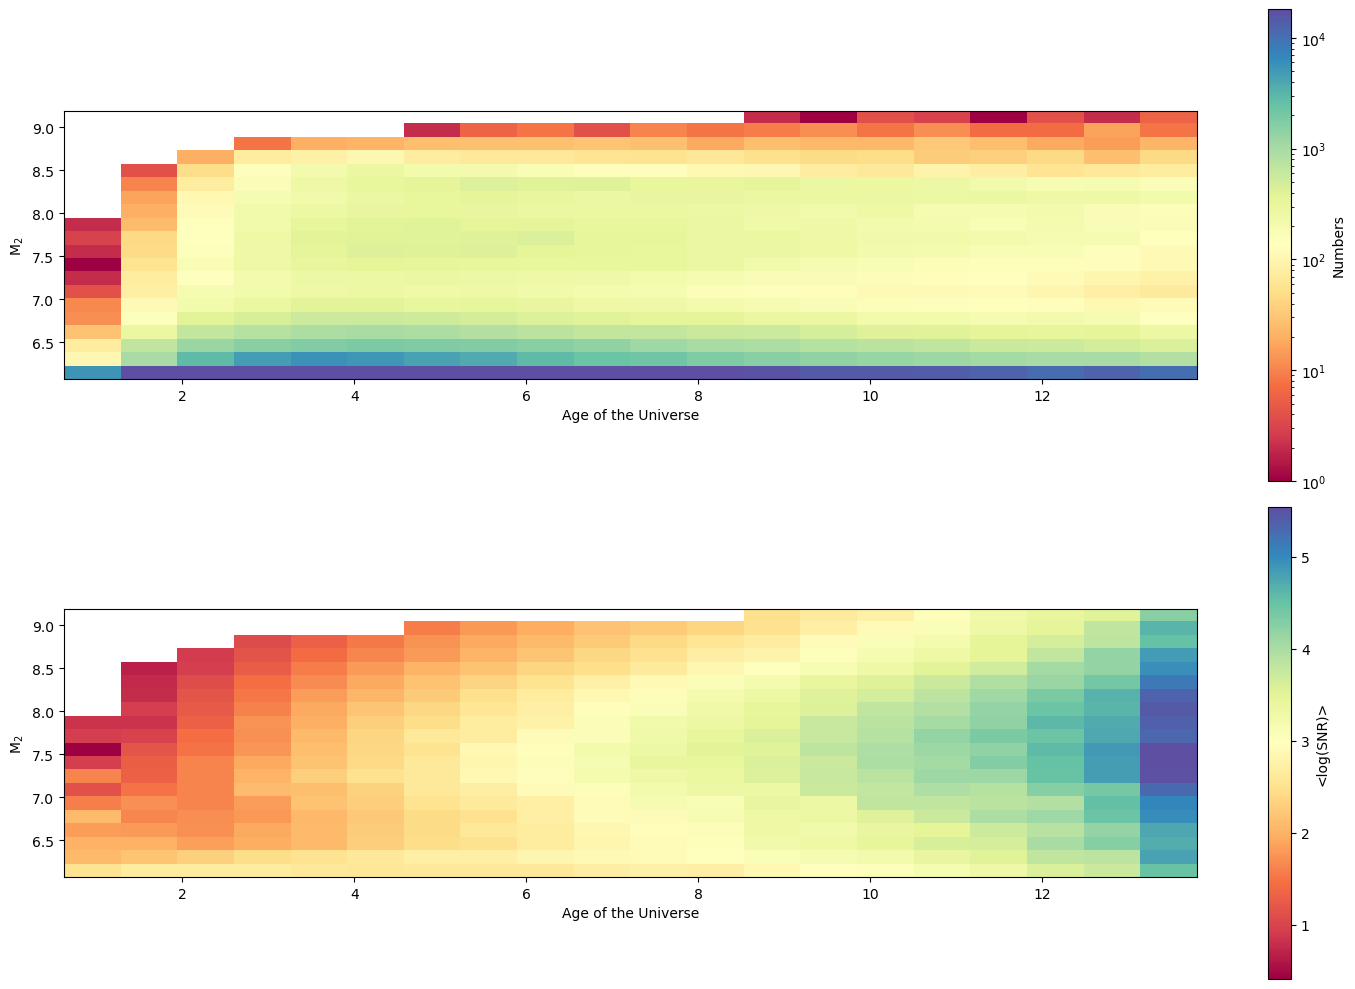

In [98]:
avg_hist(Age, np.log10(M_2),snr, labelx='Age of the Universe',labely='M$_2$',labelz='<log(SNR)>')

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


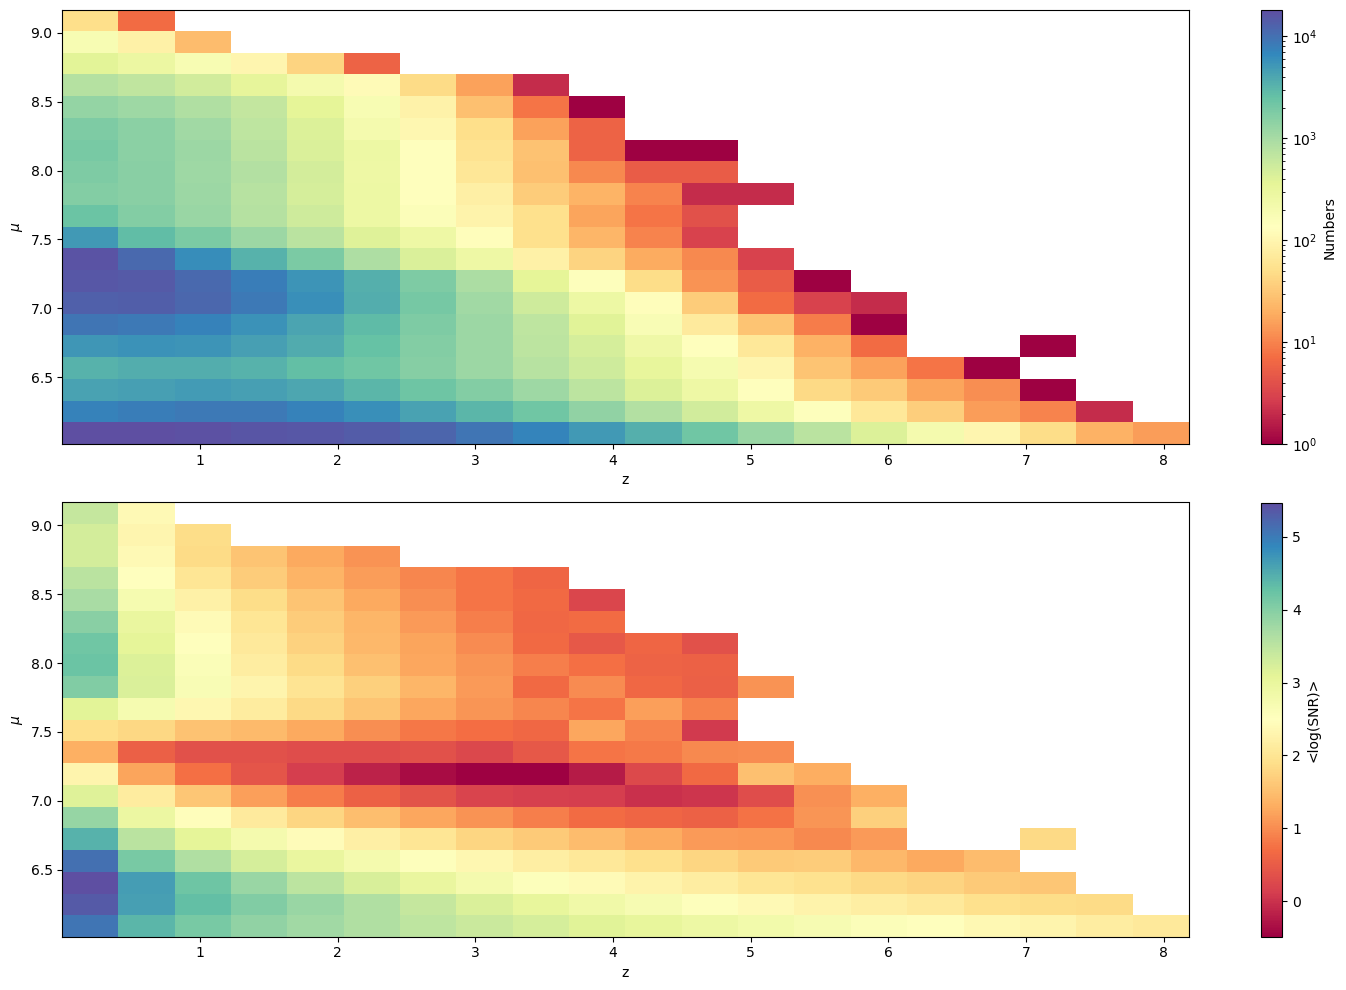

In [99]:
avg_hist(z, np.log10(mu),snr, labelx='z',labely='$\mu$',labelz='<log(SNR)>')

In [100]:
'the spike around 1e6.5 to 1e7.5 for the mu values as those have larger M1s and smaller M2s. but why they have less common in high redshifts'

'the spike around 1e6.5 to 1e7.5 for the mu values as those have larger M1s and smaller M2s. but why they have less common in high redshifts'

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


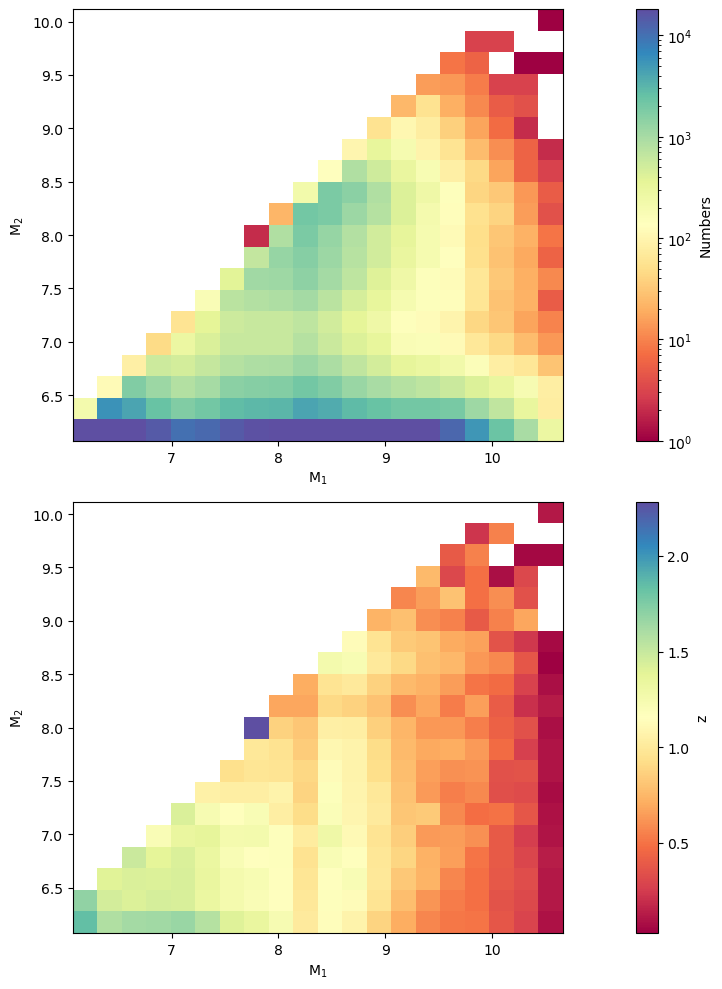

In [101]:
avg_hist(np.log10(M_1), np.log10(M_2),z,labelx='M$_1$',labely='M$_2$',labelz='z', logweight=False)

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


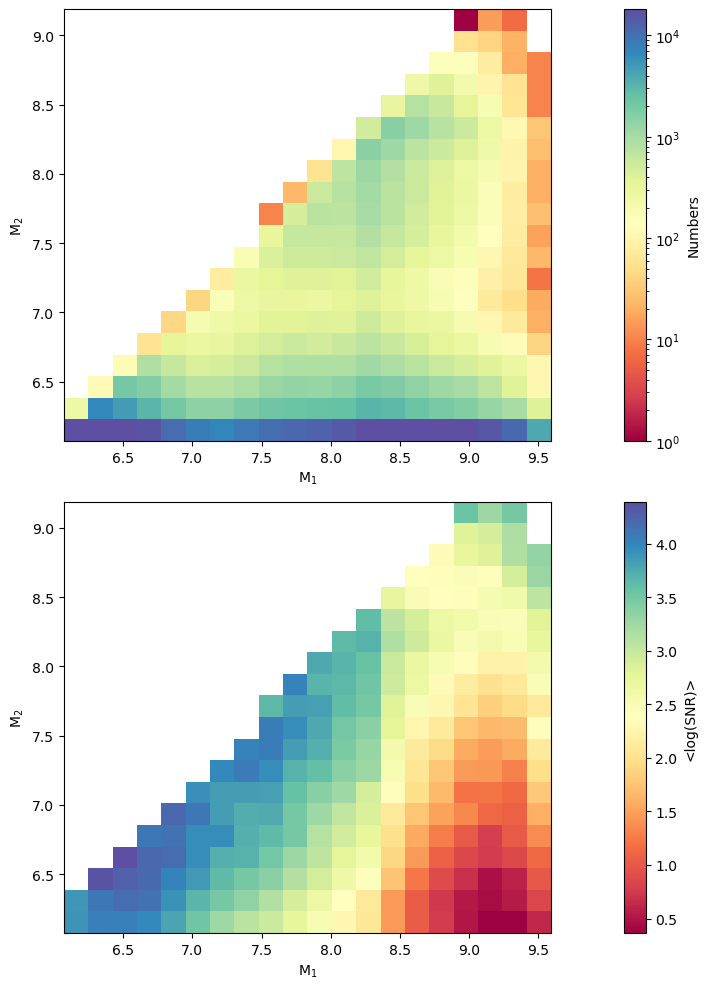

In [102]:
###avg_histM1_M2_SNR
#avg_hist(np.log10(M_1), np.log10(M_2),snr,labelx='M$_1$',labely='M$_2$',labelz='<SNR>', logweight=False, norm2=matplotlib.colors.LogNorm())
avg_hist(np.log10(M_1), np.log10(M_2),snr,labelx='M$_1$',labely='M$_2$',labelz='<log(SNR)>')
plt.savefig('avg_histM1_M2_SNR.png', dpi=300)

In [103]:
print(np.mean(snr[(q<1.5) & (snr < 1e20)]))

print(len(M_1[M_1 < 1e7]))
print(len(M_1))
print(len(M_1[M_2 < 1.5e6])/float(len(M_1)))


88855.76402152886
240445
590328
0.699616145600412


In [104]:
'$ We can see if the M_1 and M_2 is around equal mass range or close to  equal they give high snr than the merger with high and low masses $'

'$ We can see if the M_1 and M_2 is around equal mass range or close to  equal they give high snr than the merger with high and low masses $'

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


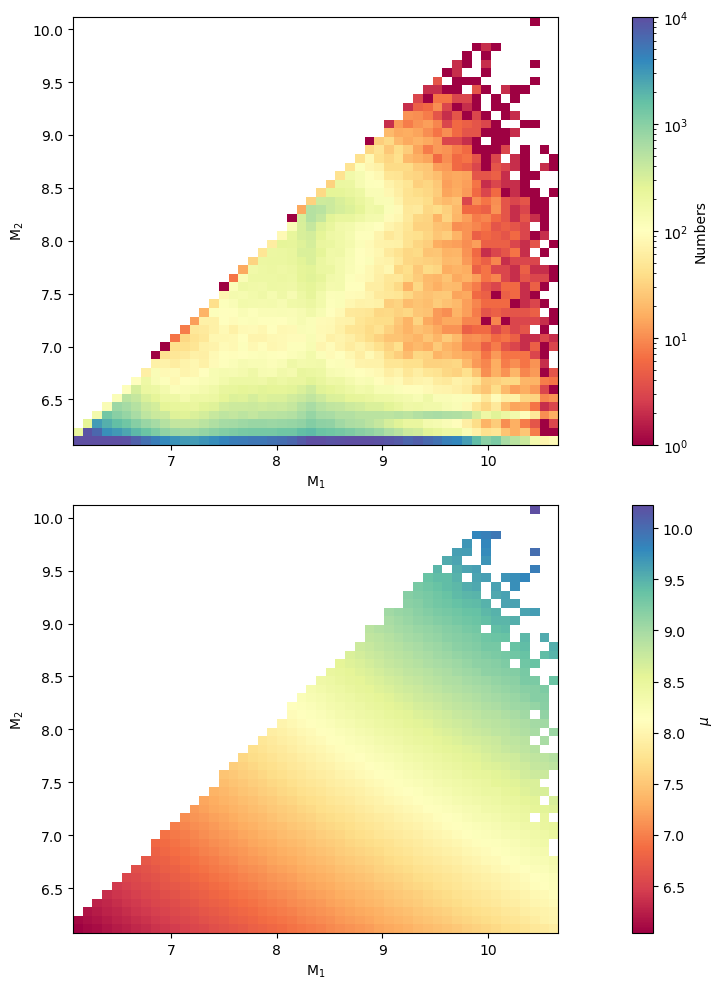

In [105]:
avg_hist(np.log10(M_1), np.log10(M_2),mu, bins=(50,50), labelx='M$_1$',labely='M$_2$',labelz='$\mu$',
         norm1=matplotlib.colors.LogNorm(vmax=1e4))

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


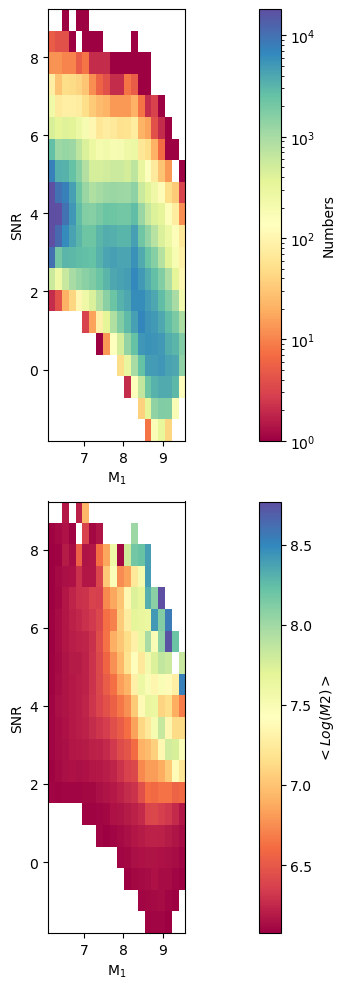

In [106]:
snr_mask=~np.isnan(snr)
avg_hist(np.log10(M_1), np.log10(snr),M_2,labelx='M$_1$',labely='SNR',labelz='$<Log(M2)>$')

In [107]:
'Snr values arourd 1e4 is very common with smaller M1s(1e6.5). as we know the average M2 is 1e6 we see a lot of it, the avg M2s with 1e7.2 mass have higher snr than M2s with larger M1 as M2s are very close to M1'


'Snr values arourd 1e4 is very common with smaller M1s(1e6.5). as we know the average M2 is 1e6 we see a lot of it, the avg M2s with 1e7.2 mass have higher snr than M2s with larger M1 as M2s are very close to M1'

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


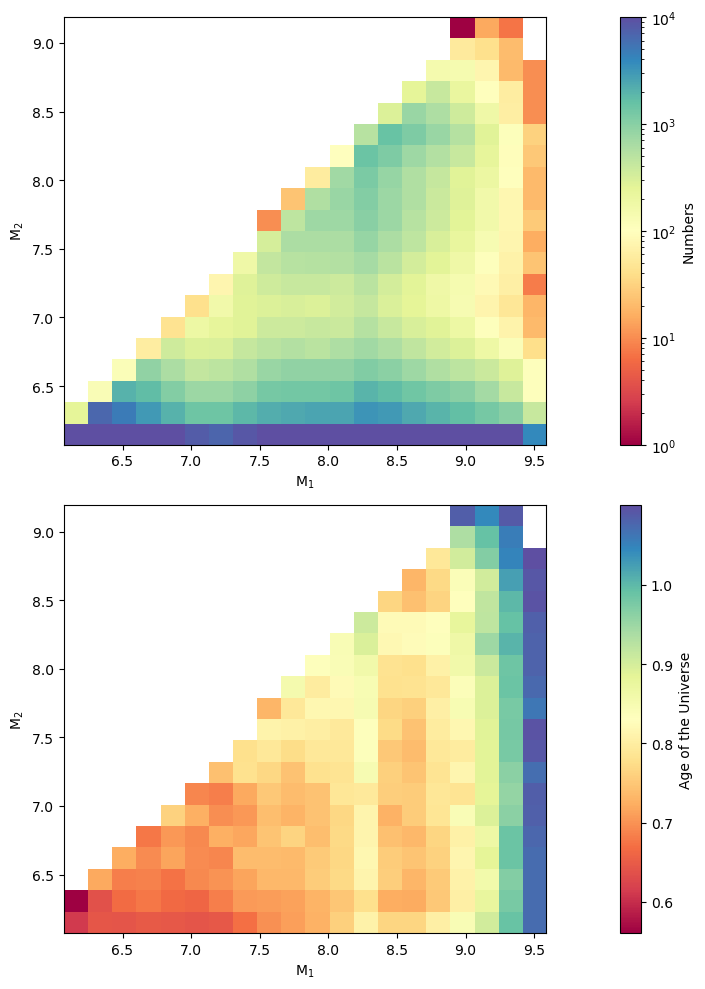

In [108]:
avg_hist(np.log10(M_1[snr_mask]),np.log10(M_2[snr_mask]), Age[snr_mask], norm2=None, labelx='M$_1$',labely='M$_2$',labelz='Age of the Universe',  norm1=matplotlib.colors.LogNorm(vmax=1e4))

In [109]:
'Large mass mergers happend at very low redshift or very close to our present time, and they are common in present as they had time to grow to that large mass'

'Large mass mergers happend at very low redshift or very close to our present time, and they are common in present as they had time to grow to that large mass'

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


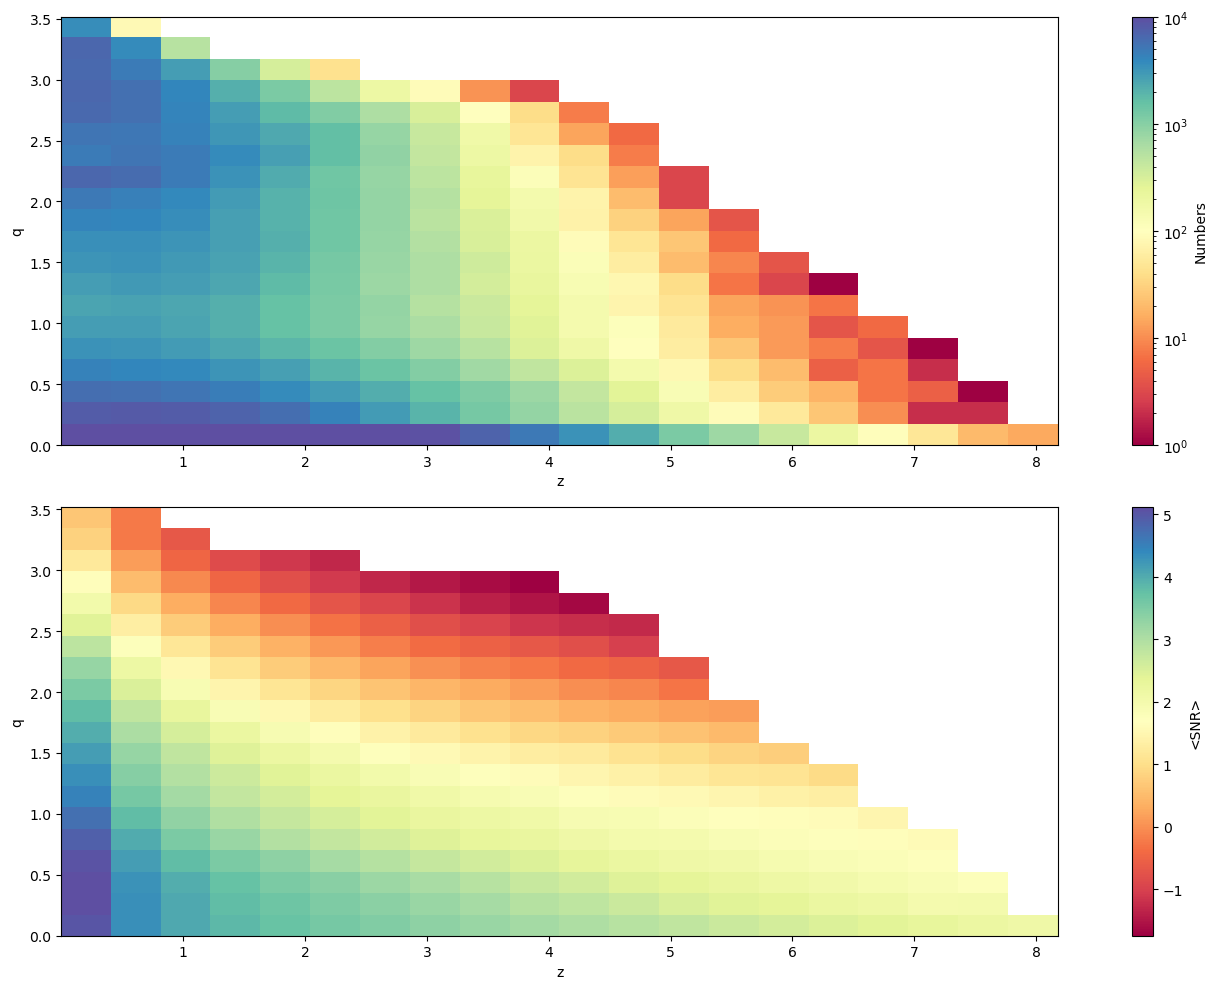

In [110]:
avg_hist(z, np.log10(q), snr, labelx='z',labely='q',labelz='<SNR>', norm1=matplotlib.colors.LogNorm(vmax=1e4))


In [111]:
'its same as z Vs M1. q mostly depends on M1 as most of the M2s are around 1e6 '

'its same as z Vs M1. q mostly depends on M1 as most of the M2s are around 1e6 '

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


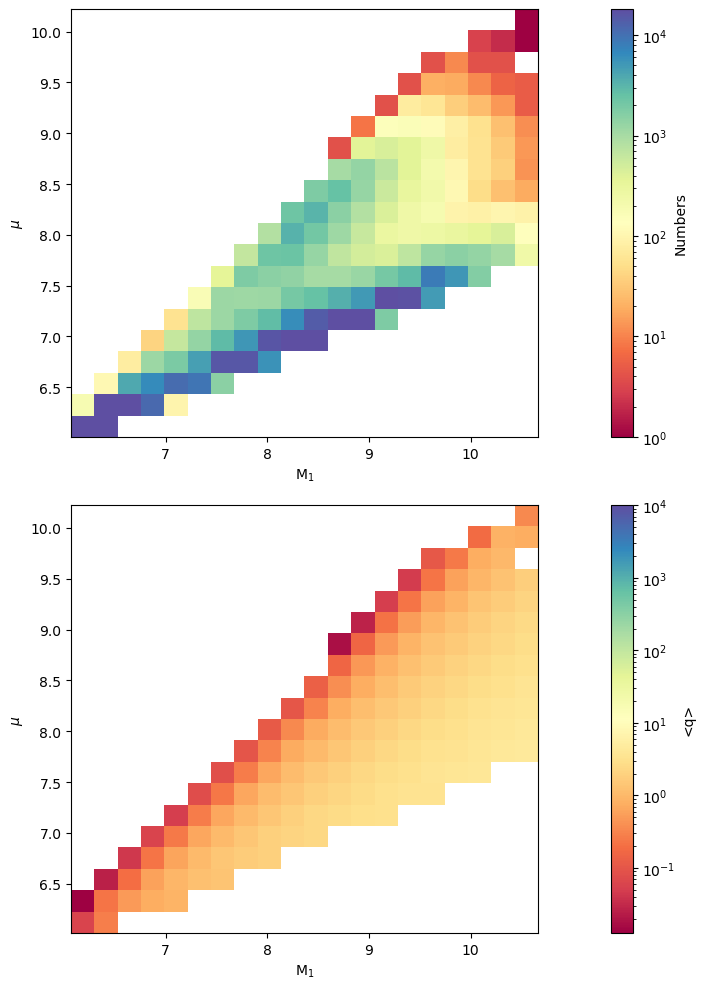

In [112]:
avg_hist(np.log10(M_1),np.log10(mu),q, labelx='M$_1$',labely='$\mu$',labelz='<q>',norm2=matplotlib.colors.LogNorm(vmax=1e4))

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


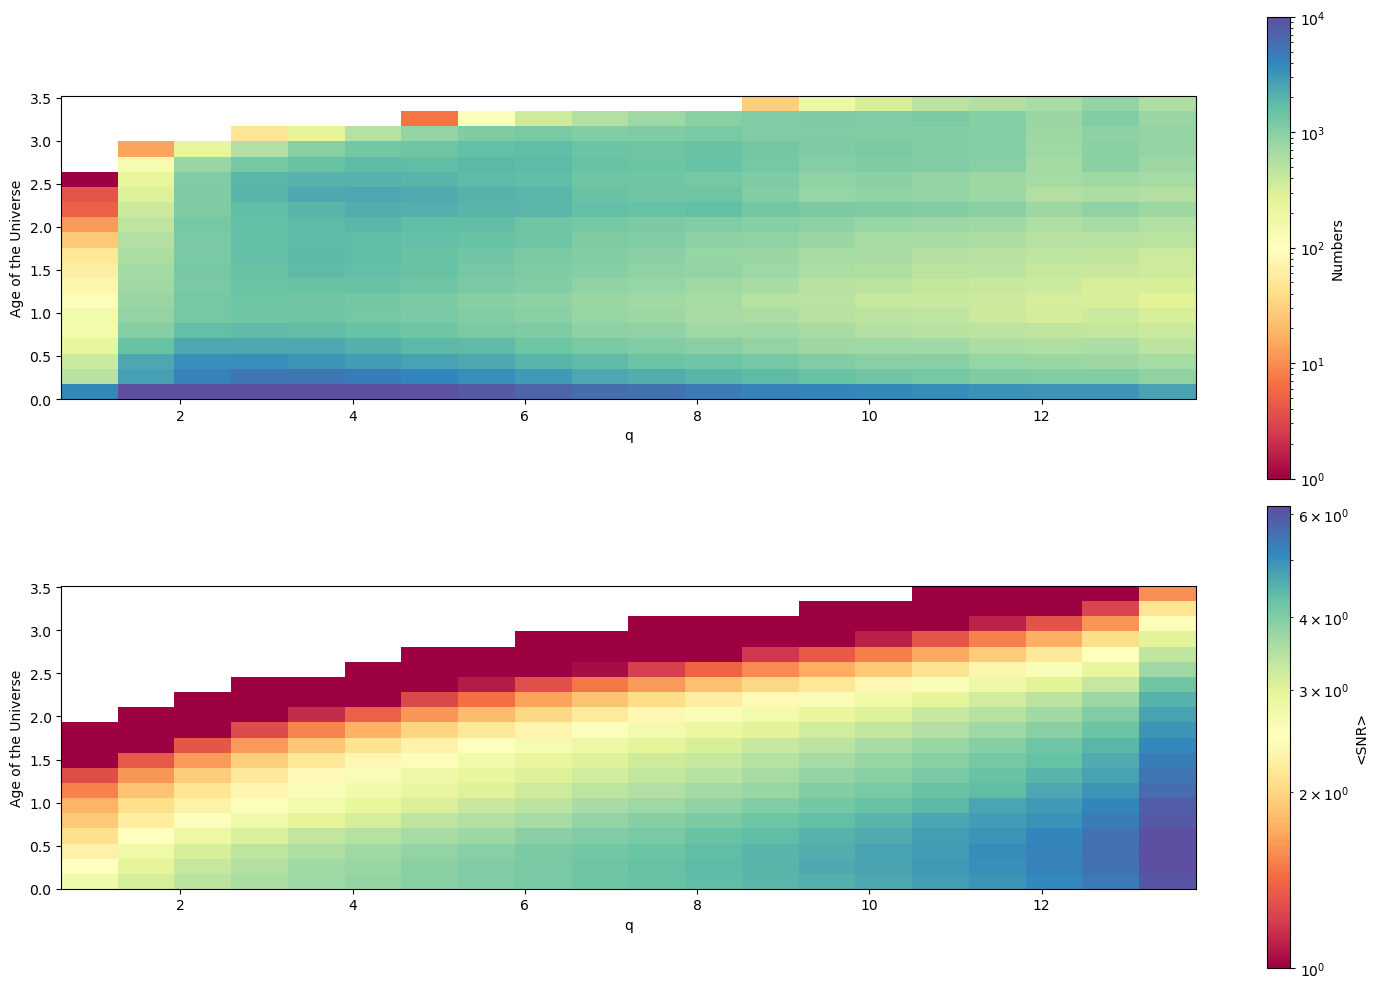

In [113]:
avg_hist(Age, np.log10(q), snr, labelx='q',labely='Age of the Universe',labelz='<SNR>',
         norm1=matplotlib.colors.LogNorm(vmax=1e4),norm2=matplotlib.colors.LogNorm(vmin=1e0))

In [114]:
def calc_rates(z,z1=0,z2=8.2,bins=90):
    z_merger_counter=np.linspace(z1,z2,bins)
    age_counter=np.array(cosmo.age(z_merger_counter))
    volume_counter=np.array(cosmo.comoving_volume(z_merger_counter))
    merger_rate=[]
    z_mid=[]
    accu_rate=[]

    for i in range(len(z_merger_counter)-1):
        z_len_mask=((z>=z_merger_counter[i])&(z<=z_merger_counter[i+1]))
        mergers=len(z[z_len_mask])
        time_dz=(age_counter[i]-age_counter[i+1])*1e9
        z_m=(z_merger_counter[i]+z_merger_counter[i+1])/2
        rate_per_volume=mergers/time_dz/302.6**3
        volume=volume_counter[i+1]-volume_counter[i]
        merger_rate_per_z=volume*rate_per_volume/(z_merger_counter[i+1]-z_merger_counter[i])
        merger_rate.append(merger_rate_per_z)
        accumulative=volume*rate_per_volume
        if i>0:
            accumulative=accumulative+accu_rate[i-1]
        accu_rate.append(accumulative)
        z_mid.append(z_m)
    return merger_rate, accu_rate, z_mid
        
        
        
def two_panel_rate_plot(z,z1=0,z2=8.2,bins=90):    
    merger_rate, accu_rate, z_mid = calc_rates(z,z1,z2,bins)
    fig, axs = plt.subplots(2, 1, sharex=True,gridspec_kw={'hspace':0})    
    axs[0].plot(z_mid, merger_rate)
    axs[0].set_ylabel('Rate per unit z [yr$^{-1}$ z$^{-1}$]')
    axs[1].plot(z_mid, accu_rate)
    axs[1].set_xlabel('z')
    axs[1].set_ylabel('Rate('+str(z1)+'<z$_m$<z) [yr$^{-1}$]')
    #plt.show()
    return

def cumulative_rate_plot(z,z1=0,z2=8.2,bins=90, linelabel=None, color=None):
    merger_rate, accu_rate, z_mid = calc_rates(z,z1,z2,bins)
    plt.plot(z_mid,accu_rate, label=linelabel, c=color)
    return accu_rate
def rate_plot(z,z1=0,z2=8.2,bins=90, linelabel=None, color=None):
    merger_rate, accu_rate, z_mid = calc_rates(z,z1,z2,bins)
    plt.plot(z_mid,merger_rate, label=linelabel, c=color)
    return merger_rate

In [115]:
def merger_rate(z,z1=0,z2=8.2,bins=90):
    z_merger_counter=np.linspace(z1,z2,bins)
    age_counter=np.array(cosmo.age(z_merger_counter))
    volume_counter=np.array(cosmo.comoving_volume(z_merger_counter))
    

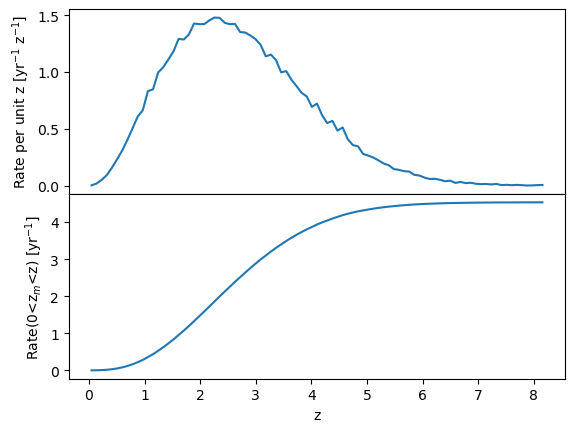

In [116]:
two_panel_rate_plot(z)

In [117]:
'At red shift 2 we can find the highest rate per unit z which is ~1.5 and the total merger rate at red shift 8 is around 4.4 '

'At red shift 2 we can find the highest rate per unit z which is ~1.5 and the total merger rate at red shift 8 is around 4.4 '

Text(0, 0.5, 'Rate (<z) [yr$^{-1}$]')

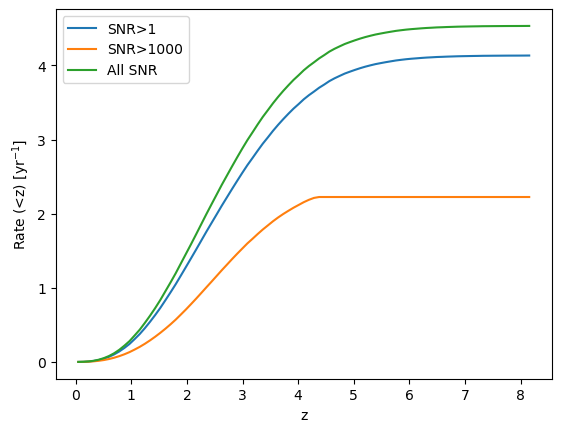

In [118]:
zmin=0
accu_1=cumulative_rate_plot(z[snr>1],bins=90, linelabel='SNR>1', z1=zmin)
accu_1000=cumulative_rate_plot(z[snr>1000],bins=90, linelabel='SNR>1000', z1=zmin)
accu_all=cumulative_rate_plot(z,bins=90, linelabel='All SNR', z1=zmin)
plt.legend()
plt.xlabel('z')
plt.ylabel('Rate (<z) [yr$^{-1}$]')

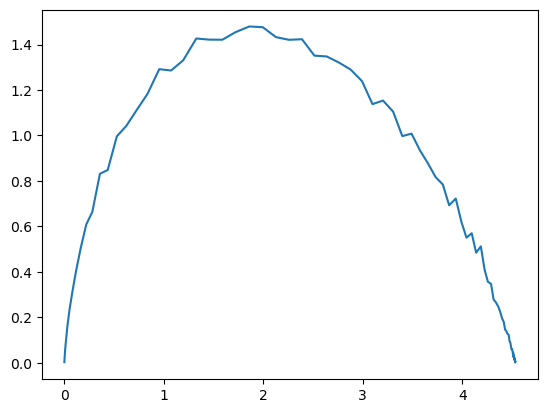

In [119]:
merger_rate, accu_rate, z_mid = calc_rates(z)
plt.plot(accu_rate,merger_rate, )

182315


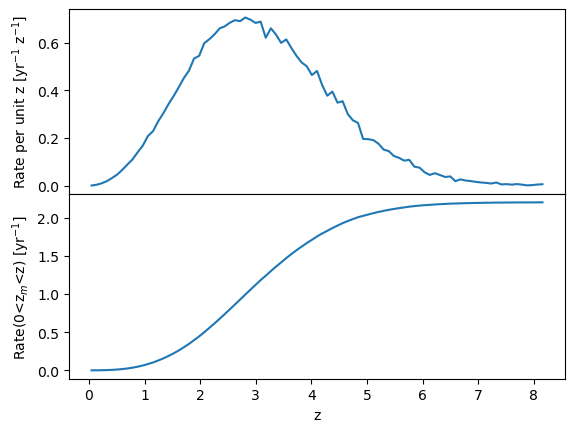

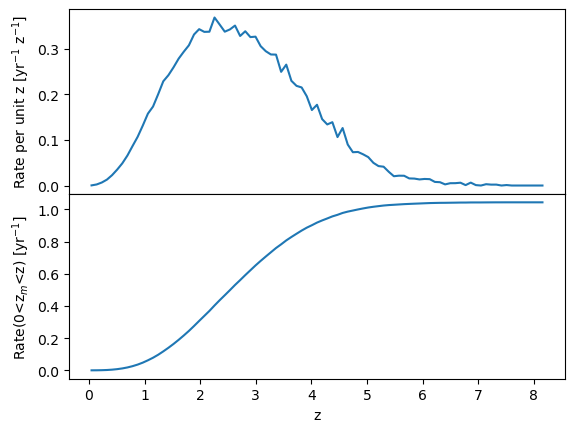

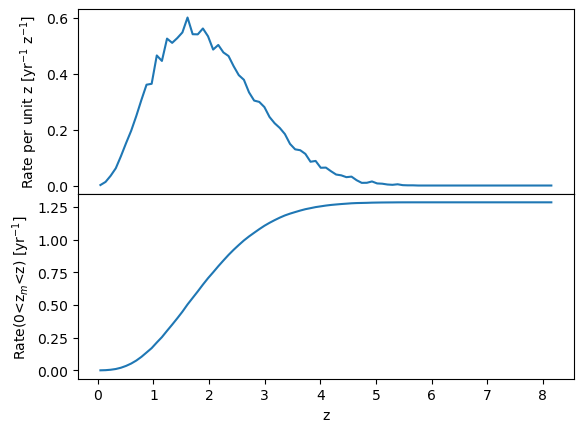

In [120]:
print(len(z[(M_1<10**6.5)]))
two_panel_rate_plot(z[(M_1<10**6.5)])
two_panel_rate_plot(z[((M_1<10**7.7)&(M_1>10**6.5))])
two_panel_rate_plot(z[(M_1>10**7.7)])

In [121]:
'we can see the mergers with M1 atrround 1e7 have low merger rate'

'we can see the mergers with M1 atrround 1e7 have low merger rate'

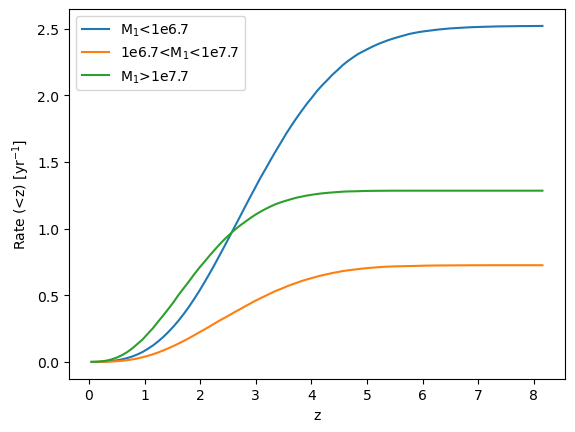

In [122]:
###M_1rate
accu_low=cumulative_rate_plot(z[(M_1<10**6.7)],linelabel='M$_1$<1e6.7')
accu_mid=cumulative_rate_plot(z[((M_1<10**7.7)&(M_1>10**6.7))],linelabel='1e6.7<M$_1$<1e7.7')
accu_high=cumulative_rate_plot(z[(M_1>10**7.7)],linelabel='M$_1$>1e7.7')
plt.legend()
plt.xlabel('z')
plt.ylabel('Rate (<z) [yr$^{-1}$]')
#plt.yscale('log')
plt.savefig('M_1accrate.png',dpi=300)

In [123]:
'mergers with mass around 1e7 have low merger rate than merger masses higher or lower than that  '

'mergers with mass around 1e7 have low merger rate than merger masses higher or lower than that  '

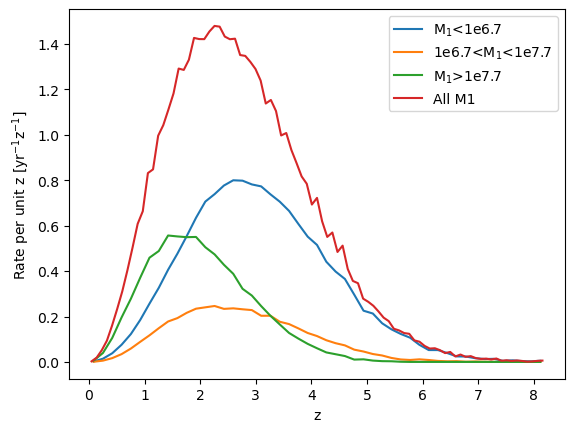

In [124]:
###M_1rate
r_bins=50
rate_low=rate_plot(z[(M_1<10**6.7)],linelabel='M$_1$<1e6.7',bins=r_bins)
rate_mid=rate_plot(z[((M_1<10**7.7)&(M_1>10**6.7))],linelabel='1e6.7<M$_1$<1e7.7',bins=r_bins)
rate_high=rate_plot(z[(M_1>10**7.7)],linelabel='M$_1$>1e7.7', bins=r_bins)
rate=rate_plot(z,linelabel='All M1')
plt.legend()
plt.xlabel('z')
plt.ylabel('Rate per unit z [yr$^{-1}$z$^{-1}$]')
#plt.plot([1.6,1.6], [0,.8])
#plt.plot([1.75,1.75], [0,.8])
#plt.yscale('log')
plt.savefig('M_1rate.png',dpi=300)

In [125]:
print(np.mean(z))

1.3083485


In [126]:
#M2, q, mu
#avg hist z, M2, snr

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


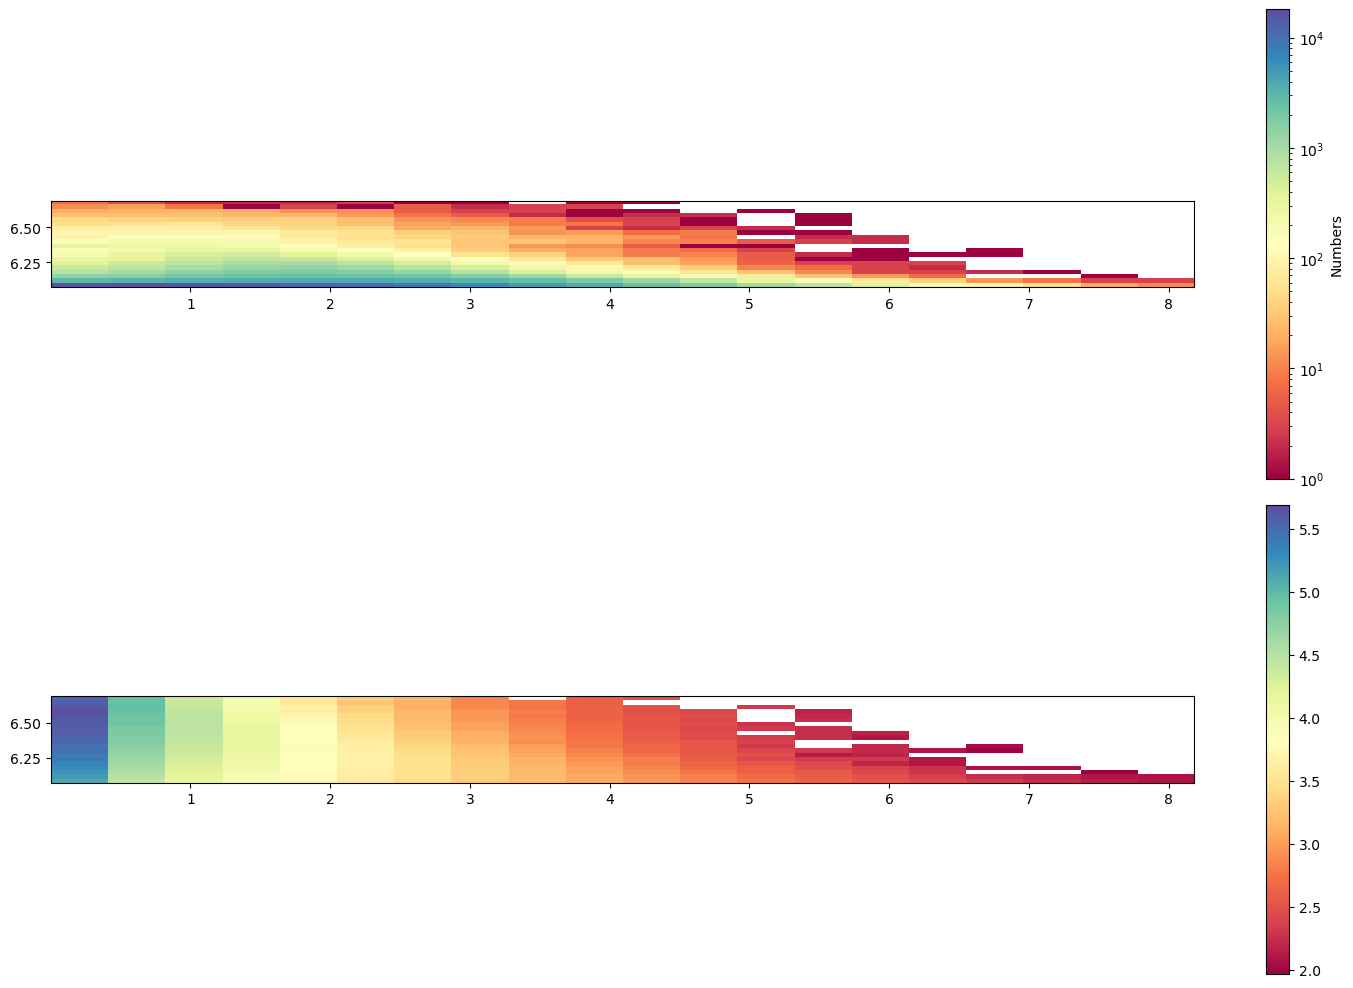

In [127]:
avg_hist(z[(M_1<10**6.7)],np.log10(M_2[(M_1<10**6.7)]),snr[(M_1<10**6.7)])

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


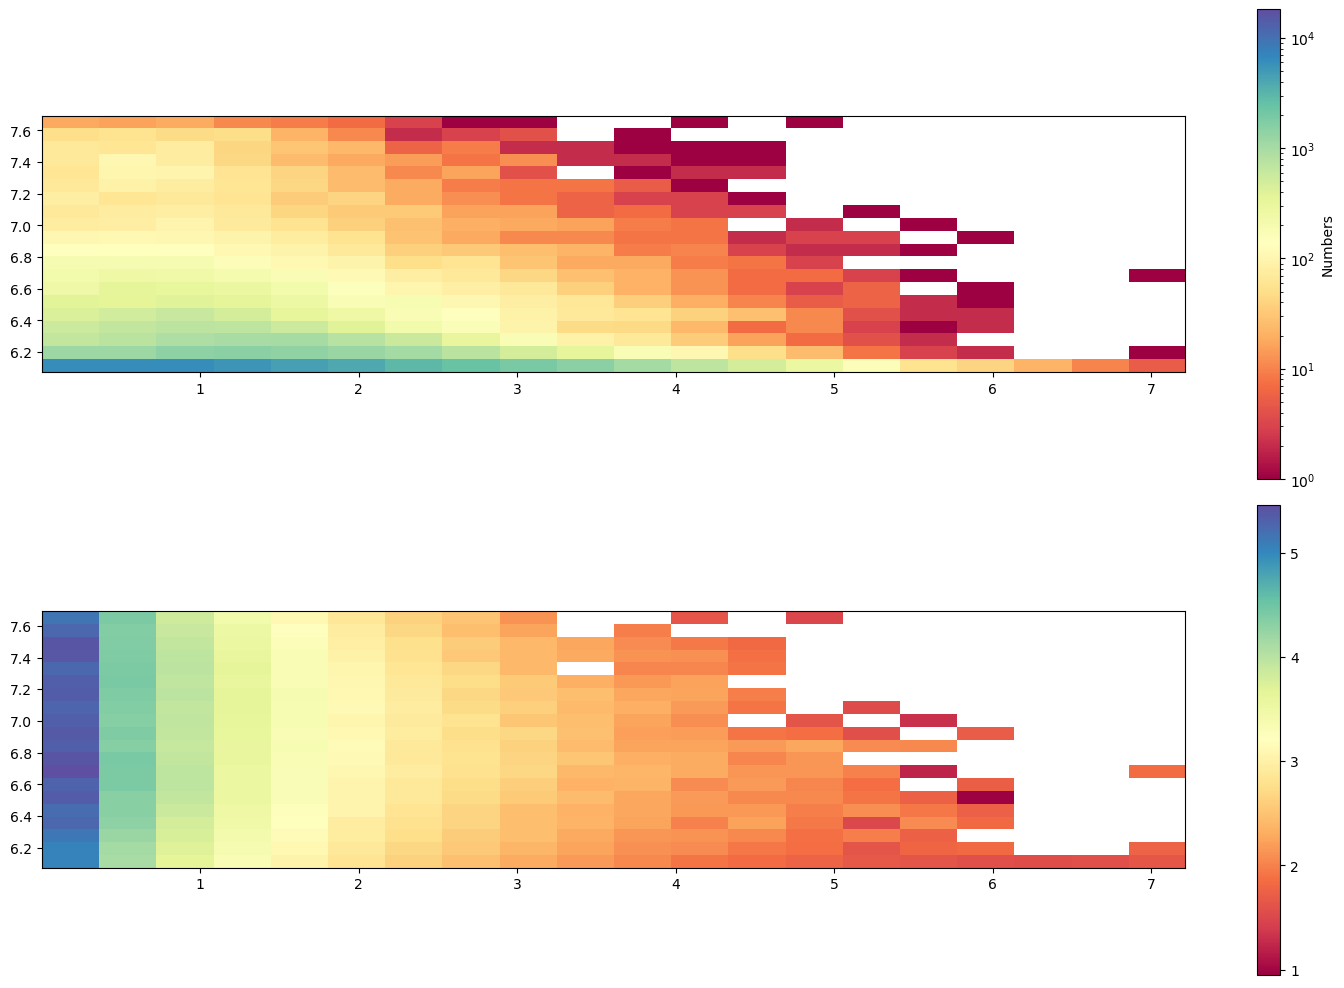

In [128]:
avg_hist(z[((M_1<10**7.7)&(M_1>10**6.7))],np.log10(M_2[((M_1<10**7.7)&(M_1>10**6.7))]),snr[((M_1<10**7.7)&(M_1>10**6.7))])

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


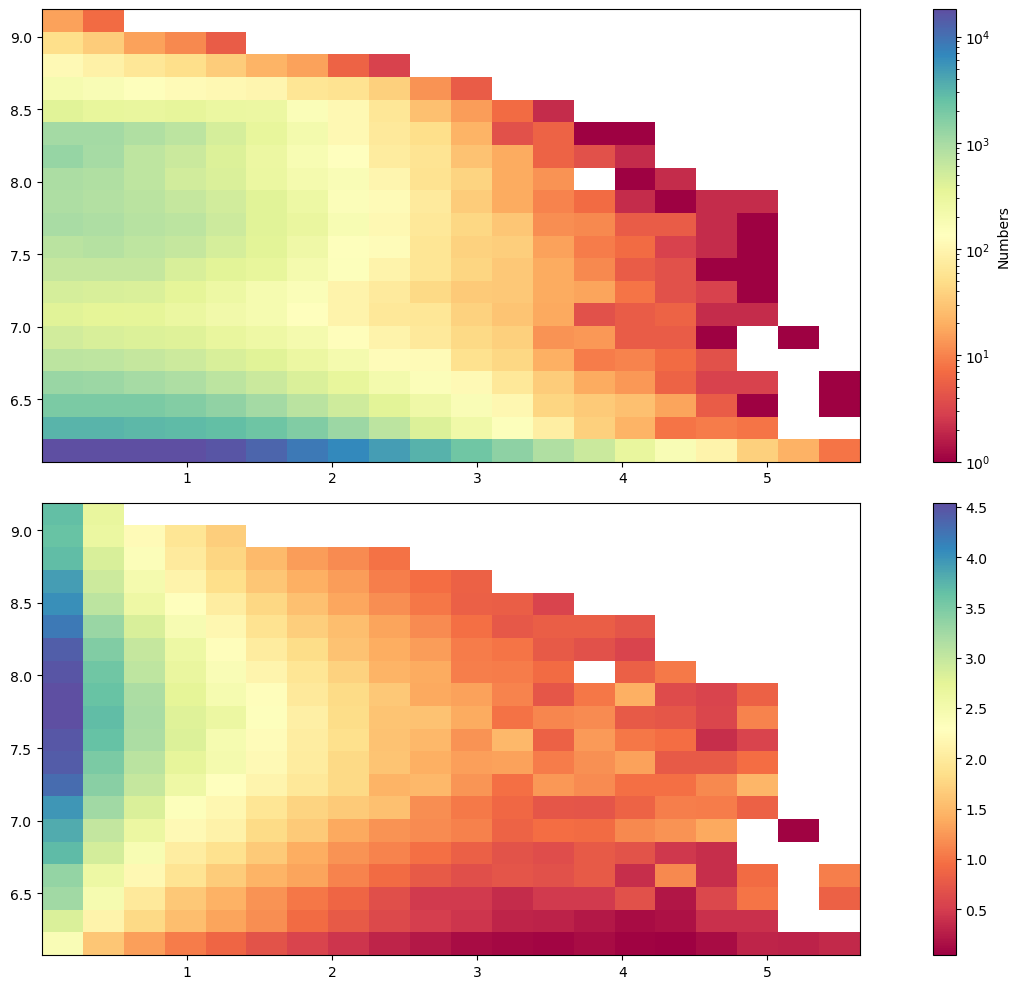

In [129]:

avg_hist(z[(M_1>10**7.7)],np.log10(M_2[(M_1>10**7.7)]),snr[(M_1>10**7.7)], norm2=None)

In [130]:
print(np.mean(np.log10(snr[(snr < 1e20) & (M_1 < 10**7.7)])))

3.8374083142223094


C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


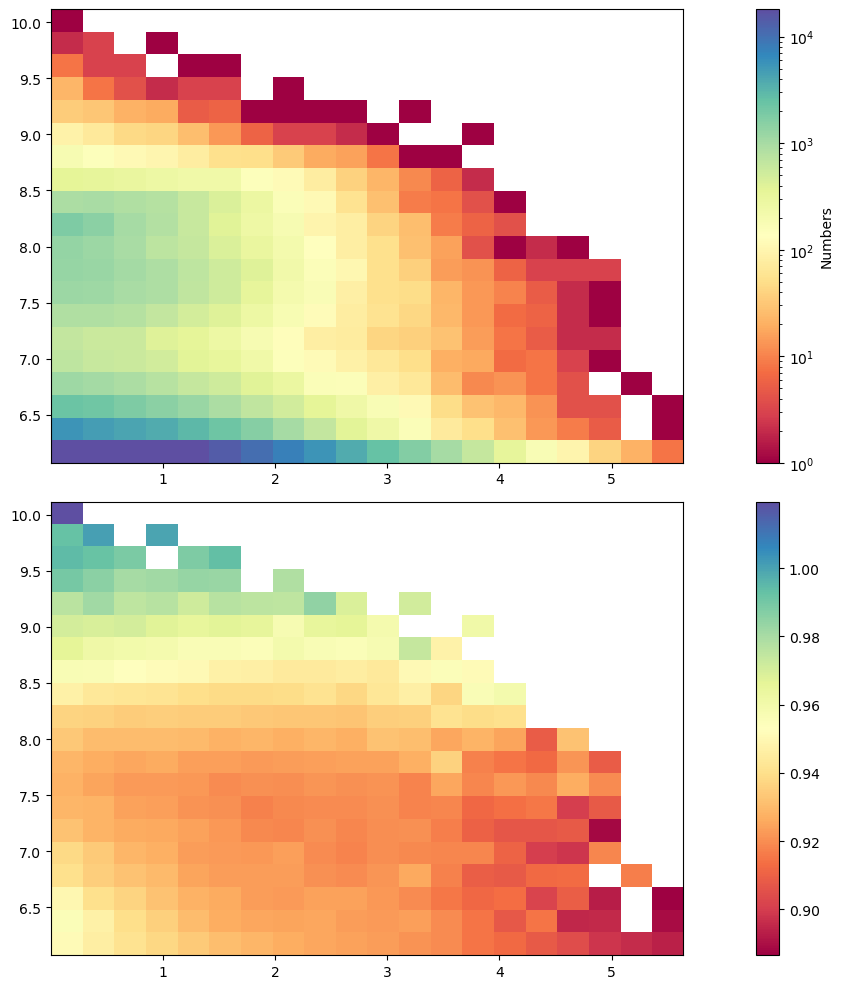

In [131]:
avg_hist(z[(M_1>10**7.7)],np.log10(M_2[(M_1>10**7.7)]),np.log10(M_1[(M_1>10**7.7)]),norm2=None)

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


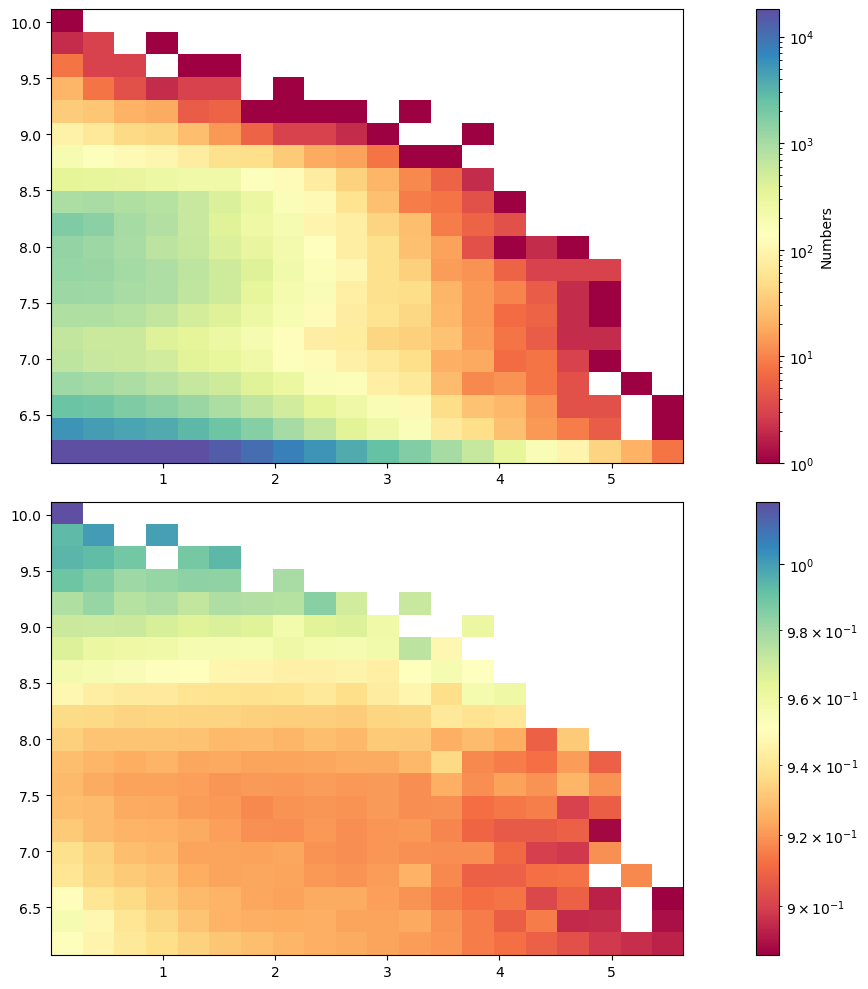

In [132]:
avg_hist(z[(M_1>10**7.7)],np.log10(M_2[(M_1>10**7.7)]),np.log10(M_1[(M_1>10**7.7)]),norm2=matplotlib.colors.LogNorm())

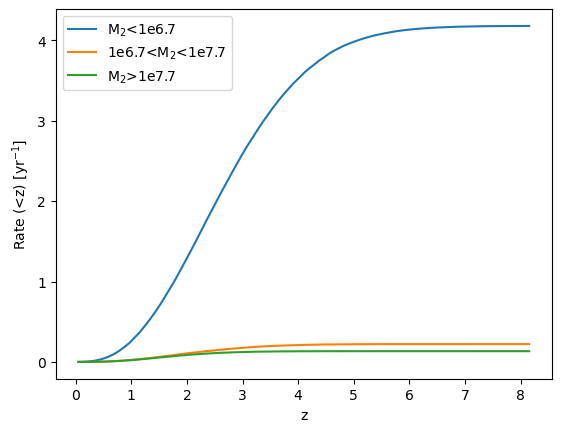

In [133]:
###M_2rate 
accu_low_m2=cumulative_rate_plot(z[(M_2<10**6.5)],linelabel='M$_2$<1e6.7')
accu_mid_m2=cumulative_rate_plot(z[((M_2<10**7.5)&(M_2>10**6.5))],linelabel='1e6.7<M$_2$<1e7.7')
accu_high_m2=cumulative_rate_plot(z[(M_2>10**7.5)],linelabel='M$_2$>1e7.7')
plt.legend()
plt.xlabel('z')
plt.ylabel('Rate (<z) [yr$^{-1}$]')
plt.savefig('M_2accrate.png',dpi=300)

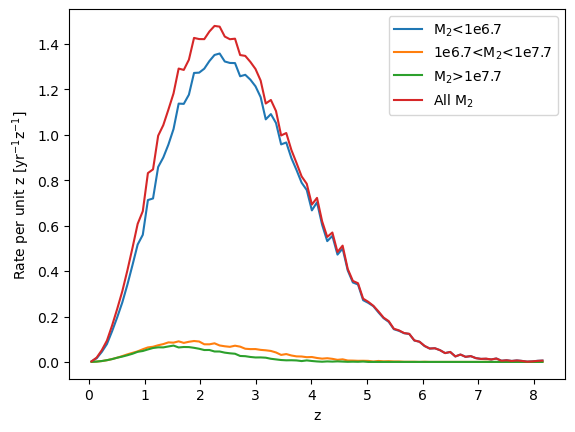

In [134]:
###M_2rate
rate_low_m2=rate_plot(z[(M_2<10**6.5)],linelabel='M$_2$<1e6.7')
rate_mid_m2=rate_plot(z[((M_2<10**7.5)&(M_2>10**6.5))],linelabel='1e6.7<M$_2$<1e7.7')
rate_high_m2=rate_plot(z[(M_2>10**7.5)],linelabel='M$_2$>1e7.7')
rate=rate_plot(z,linelabel='All M$_2$')
plt.legend()
plt.xlabel('z')
plt.ylabel('Rate per unit z [yr$^{-1}$z$^{-1}$]')
plt.savefig('M_2rate.png',dpi=300)

In [135]:
'as most of the mergers have low mass m2 it looks similar withe all mergers graph'

'as most of the mergers have low mass m2 it looks similar withe all mergers graph'

Text(0, 0.5, 'Rate per unit z [yr$^{-1}$z$^{-1}$]')

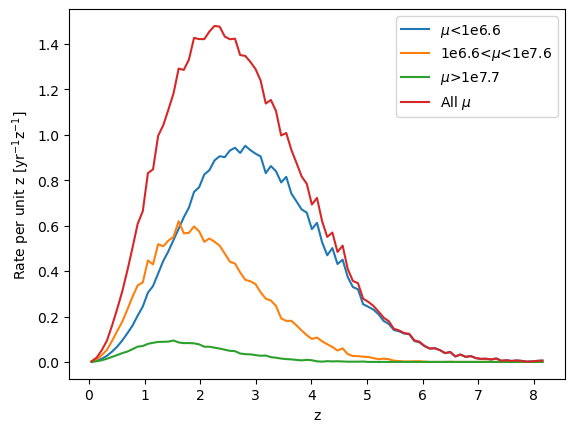

In [136]:
rate_low_mu=rate_plot(z[(mu<10**6.6)],linelabel='$\mu$<1e6.6')
rate_mid_mu=rate_plot(z[((mu<10**7.6)&(mu>10**6.6))],linelabel='1e6.6<$\mu$<1e7.6')
rate_high_mu=rate_plot(z[(mu>10**7.6)],linelabel='$\mu$>1e7.7')
rate=rate_plot(z,linelabel='All $\mu$')
plt.legend()
plt.xlabel('z')
plt.ylabel('Rate per unit z [yr$^{-1}$z$^{-1}$]')

In [137]:
def accu_percentage(M, bins=90, start=6,stop=11, linelabel=None,c=None,ls=None):
    mass_list = np.logspace(start, stop, bins)
    cumulative_percentages = []
    for i in range(len(mass_list)):
        mask_M = (M<=mass_list[i])
        percent = len(M[mask_M]) / len(M)*100
        cumulative_percentages.append(percent)
    plt.plot(mass_list,cumulative_percentages,label=linelabel,color=c,linestyle=ls)
    return 


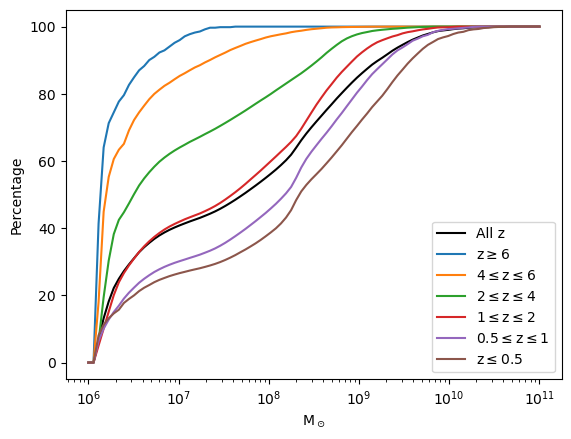

In [138]:
###M1_accu_rate
accu_percentage(M_1,linelabel='All z', c='black')
#accu_percentage(M_2,ls='--',c='black')
accu_percentage(M_1[z>=6],linelabel='z$\geq$6')
accu_percentage(M_1[((z>=4)&(z<=6))],linelabel='4$\leq$z$\leq$6')
accu_percentage(M_1[((z>=2)&(z<=4))],linelabel='2$\leq$z$\leq$4')
#m1_accu_high=accu_percentage(M_1[(z<=2)],linelabel='z$\leq$2')
#plt.plot([0,0],[10,10], color='grey', label='M$_1$')
#plt.plot([0,0],[10,10], color='grey', linestyle='--', label='M$_2$')
accu_percentage(M_1[((z>=1)&(z<=2))],linelabel='1$\leq$z$\leq$2')
accu_percentage(M_1[((z>=.5)&(z<=1))],linelabel='0.5$\leq$z$\leq$1')
accu_percentage(M_1[(z<=.5)],linelabel='z$\leq$0.5')
plt.legend()
plt.xlabel('M$_\odot$')
plt.ylabel('Percentage')
plt.xscale('log')
plt.savefig('M1_accu_rate.png',dpi=300)

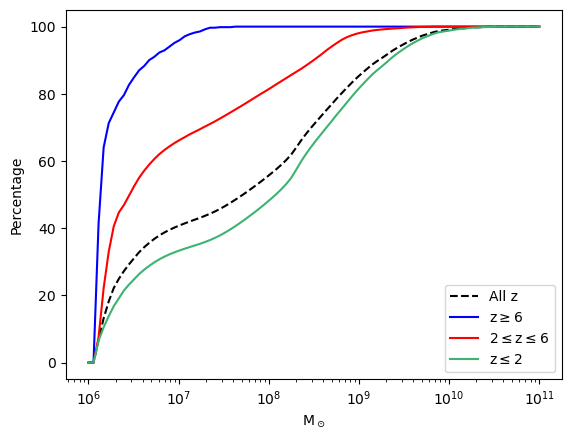

In [139]:
###M1_accu_rate
accu_percentage(M_1,linelabel='All z', c='black',ls='dashed')
#accu_percentage(M_2,ls='--',c='black')
accu_percentage(M_1[z>=6],linelabel='z$\geq$6',c='b')
accu_percentage(M_1[((z>=2)&(z<=6))],linelabel='2$\leq$z$\leq$6',c='red')
#accu_percentage(M_1[((z>=2)&(z<=4))],linelabel='2$\leq$z$\leq$4')
#m1_accu_high=accu_percentage(M_1[(z<=2)],linelabel='z$\leq$2')
#plt.plot([0,0],[10,10], color='grey', label='M$_1$')
#plt.plot([0,0],[10,10], color='grey', linestyle='--', label='M$_2$')
#accu_percentage(M_1[((z>=1)&(z<=2))],linelabel='1$\leq$z$\leq$2')
#accu_percentage(M_1[((z>=.5)&(z<=1))],linelabel='0.5$\leq$z$\leq$1')
accu_percentage(M_1[(z<=2)],linelabel='z$\leq$2',c='mediumseagreen')
plt.legend()
plt.xlabel('M$_\odot$')
plt.ylabel('Percentage')
plt.xscale('log')
plt.savefig('M1_accu_rate presentation.png',dpi=300)

In [140]:
x=5
y=7
print(x+y)

12


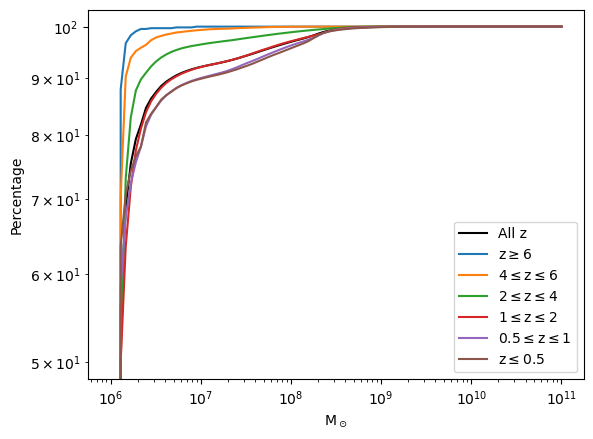

In [141]:
###M2_accu_rate
accu_percentage(M_2,linelabel='All z', c='black')
#accu_percentage(M_2,ls='--',c='black')
accu_percentage(M_2[z>=6],linelabel='z$\geq$6')
accu_percentage(M_2[((z>=4)&(z<=6))],linelabel='4$\leq$z$\leq$6')
accu_percentage(M_2[((z>=2)&(z<=4))],linelabel='2$\leq$z$\leq$4')
#m1_accu_high=accu_percentage(M_1[(z<=2)],linelabel='z$\leq$2')
#plt.plot([0,0],[10,10], color='grey', label='M$_1$')
#plt.plot([0,0],[10,10], color='grey', linestyle='--', label='M$_2$')
accu_percentage(M_2[((z>=1)&(z<=2))],linelabel='1$\leq$z$\leq$2')
accu_percentage(M_2[((z>=.5)&(z<=1))],linelabel='0.5$\leq$z$\leq$1')
accu_percentage(M_2[(z<=.5)],linelabel='z$\leq$0.5')
plt.legend()
plt.xlabel('M$_\odot$')
plt.ylabel('Percentage')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1e6,3e8)
#plt.ylim(50,100)
plt.savefig('M2_accu_rate.png',dpi=300)

(1000000.0, 44000000000.0)

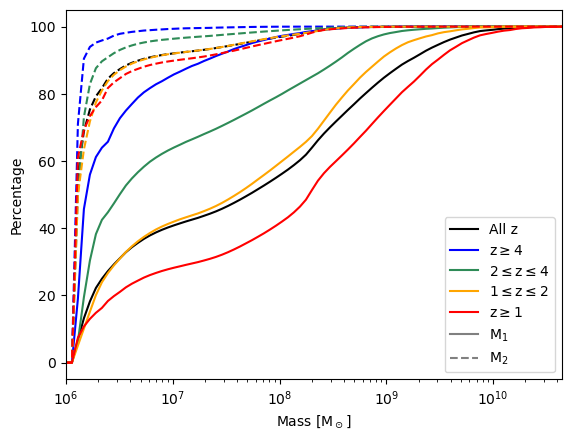

In [142]:
accu_percentage(M_1,linelabel='All z', c='black')
accu_percentage(M_2,ls='--',c='black')
accu_percentage(M_1[z>=4],linelabel='z$\geq$4',c='b')
accu_percentage(M_2[z>=4],c='b',ls='--')
accu_percentage(M_1[((z>=2)&(z<=4))],linelabel='2$\leq$z$\leq$4', c='seagreen')
accu_percentage(M_2[((z>=2)&(z<=4))], c='seagreen',ls='--')
accu_percentage(M_1[((z>=1)&(z<=2))],linelabel='1$\leq$z$\leq$2',c='orange')
accu_percentage(M_2[((z>=1)&(z<=2))],c='orange',ls='--')
accu_percentage(M_1[z<=1],linelabel='z$\geq$1',c='r')
accu_percentage(M_2[z<=1],c='r',ls='--')
plt.plot([0,0],[10,10], color='grey', label='M$_1$')
plt.plot([0,0],[10,10], color='grey', linestyle='--', label='M$_2$')
plt.legend()
plt.xlabel('Mass [M$_\odot$]')
plt.ylabel('Percentage')
plt.xscale('log')
plt.xlim(1e6,4.4e10)
#plt.yscale('log')

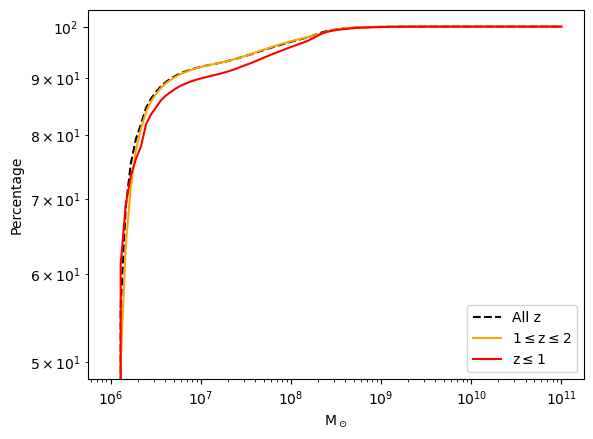

In [143]:
accu_percentage(M_2,ls='--',linelabel='All z',c='black')
accu_percentage(M_2[((z>=1)&(z<=2))],linelabel='1$\leq$z$\leq$2',c='orange')

accu_percentage(M_2[z<=1],linelabel='z$\leq$1',c='r')
plt.legend()
plt.xlabel('M$_\odot$')
plt.ylabel('Percentage')
plt.xscale('log')
plt.yscale('log')


In [144]:
print(len(M_2[((z>=1)&(z<=2))])/len(M_2))
print(len(M_2[z<=1])/len(M_2))

0.2902301771218712
0.4838276348064127


In [145]:
len(M_1[(z>6)&(M_1<10**6.5)])/len(M_1[(z>6)])

0.8475120385232745

In [146]:
10**6.2



1584893.1924611141

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


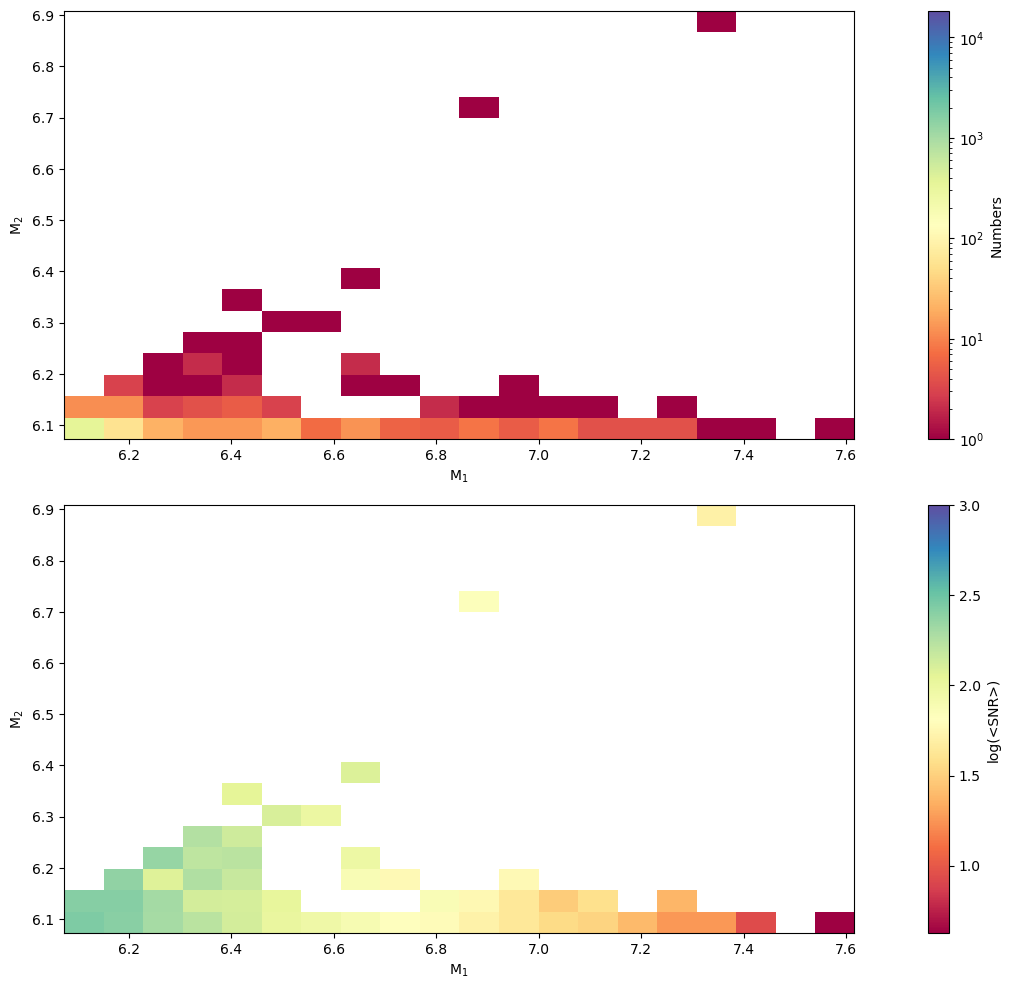

In [147]:
###avghist_M1_M2_SNR[z>6]
avg_hist(np.log10(M_1[z>6]),np.log10(M_2[z>6]),snr[z>6],labelx='M$_1$',labely='M$_2$',labelz='log(<SNR>)',vmax=3)
plt.savefig('avghist_M1_M2_SNRhigh.png',dpi=300)

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


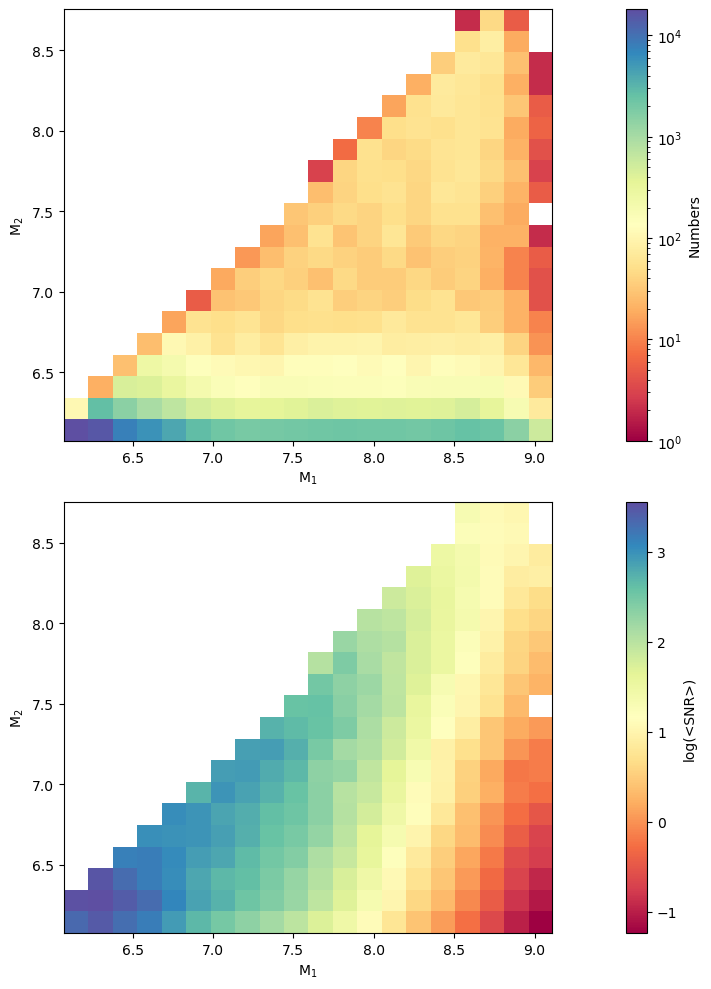

In [148]:
###avghist_M1_M2_SNR[2-6]
avg_hist(np.log10(M_1[((z<=6)&(z>=2))]),np.log10(M_2[((z<=6)&(z>=2))]),snr[((z<=6)&(z>=2))],labelx='M$_1$',labely='M$_2$',labelz='log(<SNR>)',)
plt.savefig('avghist_M1_M2_SNRmid.png',dpi=300)

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


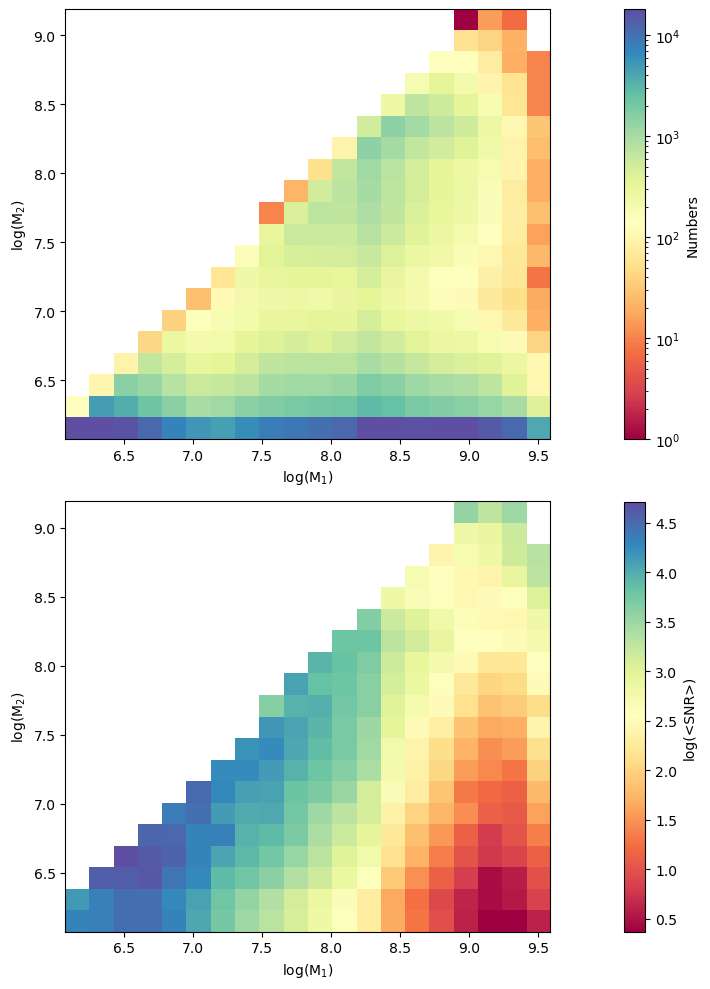

In [149]:
###avghist_M1_M2_SNR[0-2]
avg_hist(np.log10(M_1[(z<=2)]),np.log10(M_2[(z<=2)]),snr[((z<=2))],labelx='log(M$_1$)',labely='log(M$_2$)',labelz='log(<SNR>)',)
plt.savefig('avghist_M1_M2_SNRlow.png',dpi=300)

In [150]:
len(M_1[((z<=2)&(M_1<10**7.78))])/len(M_1[z<=2])

0.4349422691422219

In [151]:
len(M_1[((z>4)&(M_1<10**7.78))])/len(M_1[(z>4)])

0.9540645689714012

In [152]:
gmean(M_2[(z<=2)&(z>=1)])

2023707.7559808048

In [153]:
10**6.7

5011872.336272725

In [154]:
len(M_1[z<=2])

456948

In [155]:
gmean(M_2
        [z>4])

1342306.0654487626

In [156]:
len(M_2[((z<=2)&(z>=1)&(M_2<10**6.5))])/len(M_2[((z<=2)&(z>=1))])

0.8690896568630312

In [157]:
len(M_1[((z<=6)&(z>=2)&(M_1<10**6.5))])/len(M_1[((z<=6)&(z>=2))])

0.521787928320164

In [158]:
10**6.5



3162277.6601683795

In [159]:
gmean(M_2[(z<2)&(z>1)])

2023707.7559808048

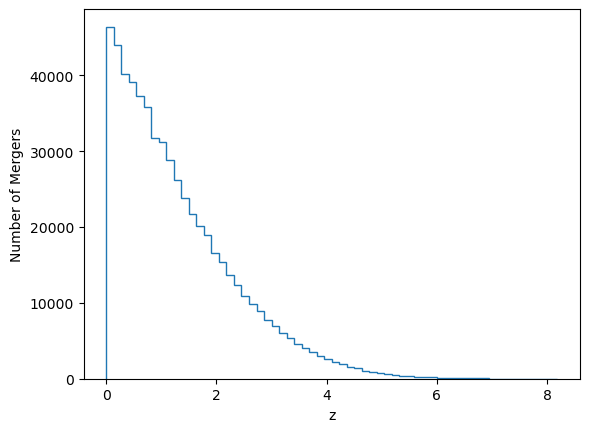

In [160]:
###z_hist
trhistdataz =plt.hist(z, bins=60, histtype='step', density=False)
plt.xlabel('z')
plt.ylabel('Number of Mergers')
plt.savefig('zVsmergers.png',dpi=300)

In [161]:
len(z[z<2])/len(z)

0.7740578119282839

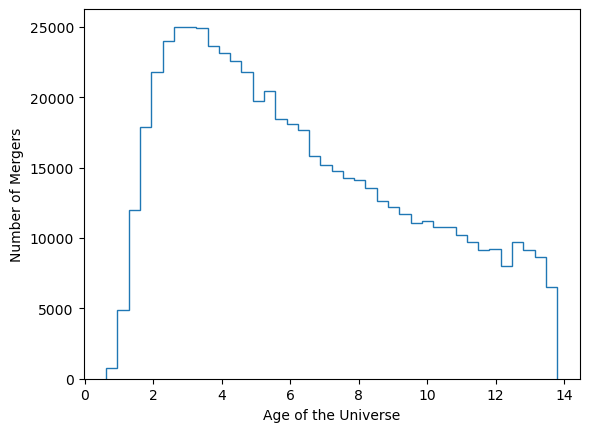

In [162]:
###AgeVsmergers
histdataage =plt.hist(Age, bins=40, histtype='step', density=False)
plt.xlabel('Age of the Universe')
plt.ylabel('Number of Mergers')

plt.savefig('AgeVsmergers.png',dpi=300)

In [163]:
print(histdataage[0])

[  731.  4857. 12005. 17893. 21820. 23972. 25018. 24977. 24923. 23670.
 23175. 22560. 21825. 19766. 20437. 18462. 18108. 17652. 15829. 15216.
 14779. 14271. 14112. 13531. 12622. 12214. 11677. 11067. 11216. 10758.
 10785. 10237.  9696.  9170.  9248.  8019.  9684.  9175.  8629.  6542.]


Text(0, 0.5, 'Mergers Density [Mpc$^{-3}$]')

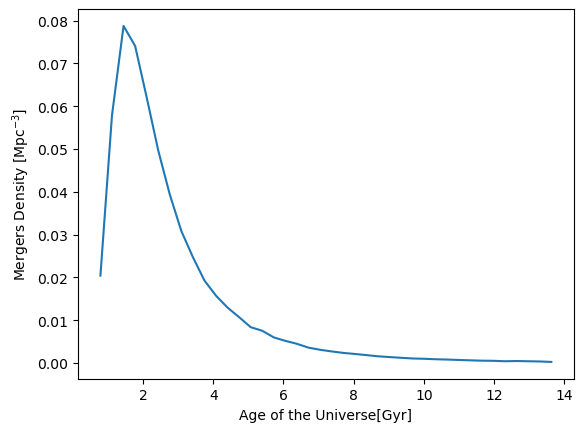

In [164]:
z_hist=np.array(z_at_value(cosmo.age, histdataage[1]*u.Gyr, method='Bounded'))
merg_num=histdataage[0]
age_data=histdataage[1]
vol_den1=[]
age_mid1=[]
for i in range(len(z_hist)-1):
    volume=(302.6/(1+z_hist[i]))**3
    volden1=merg_num[i]/volume
    age_m1=(age_data[i]+age_data[i+1])/2
    age_mid1.append(age_m1)
    vol_den1.append(volden1)

plt.plot(age_mid1,vol_den1)
#plt.yscale('log')
plt.xlabel('Age of the Universe[Gyr]')
plt.ylabel('Mergers Density [Mpc$^{-3}$]')

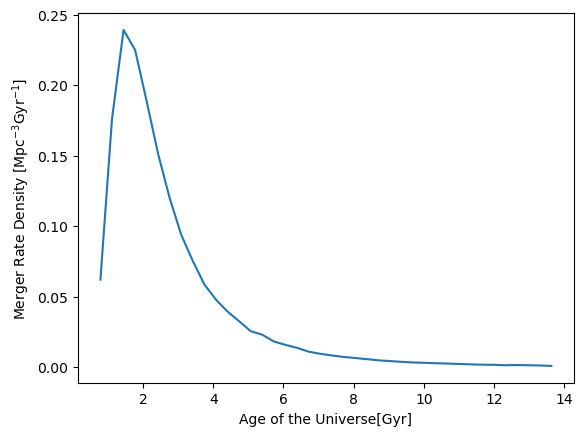

In [165]:
age_diff=age_data[4]-age_data[3]
age_diff_2=age_data[-1]-age_data[-2]
if np.abs((age_diff_2-age_diff)/age_diff)<0.0001:
    plt.plot(age_mid1,vol_den1/age_diff)
    
    plt.xlabel('Age of the Universe[Gyr]')
    plt.ylabel('Merger Rate Density [Mpc$^{-3}$Gyr$^{-1}$]')
else:
    print("bin sizes are not equal")
#print(age_diff_2,age_diff)
#print(np.abs((age_diff_2-age_diff)/age_diff))


In [166]:
print(age_diff)

0.32942328188702685


In [167]:
z_at_value(cosmo.age, 2*u.Gyr, method='Bounded')

<Quantity 3.19718416 redshift>

In [168]:
cosmo.age(3.187)

<Quantity 2.00723746 Gyr>

In [169]:
print(gmean(M_2))


1971272.1948351786


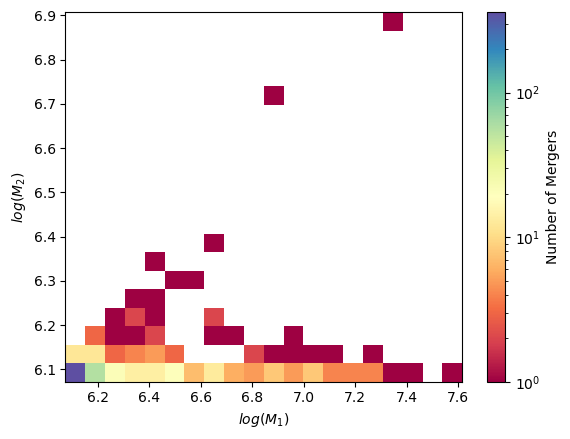

In [170]:
plt.hist2d(np.log10(M_1[z>6]),np.log10(M_2[z>6]), bins=20, density=False, cmap='Spectral',norm=matplotlib.colors.LogNorm())
plt.xlabel("$log(M_1)$")
plt.ylabel("$log(M_2)$")
plt.colorbar(label='Number of Mergers')
plt.savefig("high_z.png",dpi=300)
plt.show()


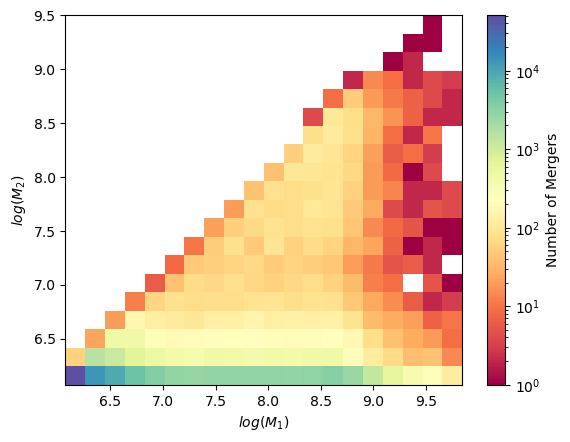

In [171]:
plt.hist2d(np.log10(M_1[((z>2)&(z<6))]),np.log10(M_2[((z>2)&(z<6))]), bins=20, density=False, cmap='Spectral',norm=matplotlib.colors.LogNorm())
plt.colorbar(label='Number of Mergers')
plt.xlabel("$log(M_1)$")
plt.ylabel("$log(M_2)$")

plt.savefig("mid_z.png",dpi=300)
plt.show()

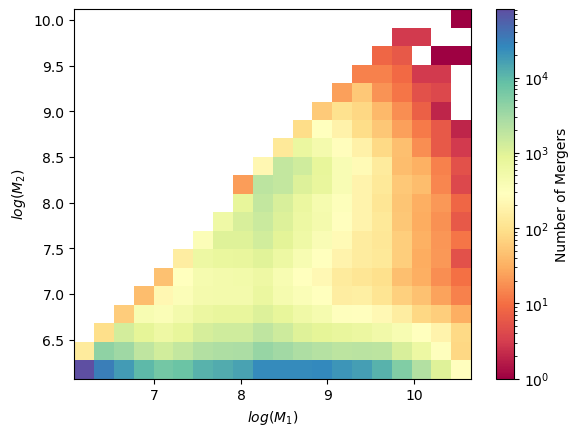

In [172]:
plt.hist2d(np.log10(M_1[z<2]),np.log10(M_2[z<2]), bins=20, density=False, cmap='Spectral',norm=matplotlib.colors.LogNorm())
plt.xlabel("$log(M_1)$")
plt.ylabel("$log(M_2)$")
plt.colorbar(label='Number of Mergers')
plt.savefig("low_z.png",dpi=300)
plt.show()

In [173]:
def New_Rates(z,z1=0,z2=8.2,bins=90, sim_L=302.6):
    z_counter=np.linspace(z1,z2,bins)
    time_counter=np.array(cosmo.age(z_counter))
    volume_counter=np.array(cosmo.comoving_volume(z_counter))
    merger_rate_per_dz=[]
    z_mid=[]
    accu_rate=[]

    for i in range(len(z_counter)-1):
        z_mask=((z>=z_counter[i])&(z<z_counter[i+1]))
        mergers=len(z[z_mask])
        dz=(z_counter[i+1]-z_counter[i])
        dt=(time_counter[i]-time_counter[i+1])*1e9
        z_m=(z_counter[i]+z_counter[i+1])/2

        dn_per_dz_dV_sim=mergers/dz/sim_L**3
        volume_r=volume_counter[i+1]-volume_counter[i]

        dN_per_dt_dz=dn_per_dz_dV_sim*(dz/dt)*(volume_r/dz)*(dz/(z_m+1))/dz
        merger_rate_per_dz.append(dN_per_dt_dz)
        accumulative=dN_per_dt_dz*dz
        if i>0:
            accumulative=accumulative+accu_rate[i-1]
        accu_rate.append(accumulative)
        z_mid.append(z_m)
    return merger_rate_per_dz, accu_rate, z_mid
def new_rate_plots(z,z1=0,z2=8.2,bins=90):
    merger_rate_per_dz, accu_rate, z_mid = New_Rates(z,z1=z1,z2=z2,bins=bins)
    plt.plot(z_mid,accu_rate)
    plt.plot(z_mid, merger_rate_per_dz)


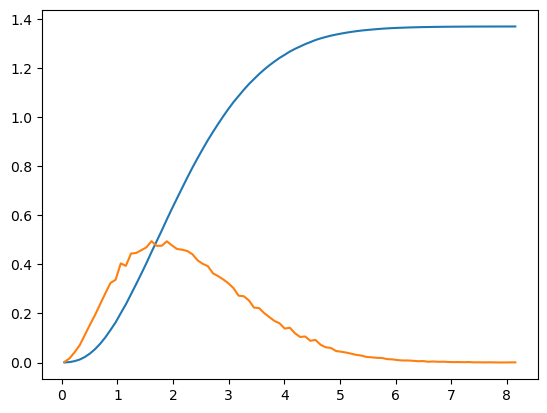

In [174]:
new_rate_plots(z)

C:\Users\karma\AppData\Local\Temp\ipykernel_27200\1422429526.py:25: RuntimeWarning: invalid value encountered in divide
  plt.imshow(H_z/H_num, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],


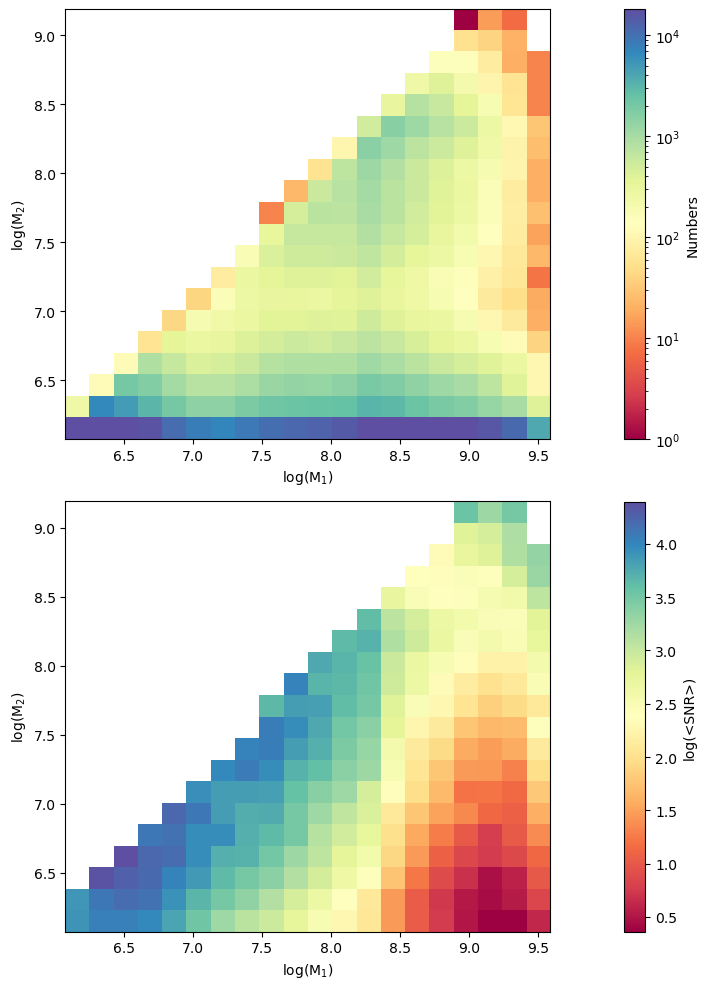

In [175]:
###avghist_M1_M2_SNR_all
avg_hist( np.log10(M_1),np.log10(M_2),snr,labelx='log(M$_1$)',labely='log(M$_2$)',labelz='log(<SNR>)',)
plt.savefig('avghist_M1_M2_SNR_all.png',dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


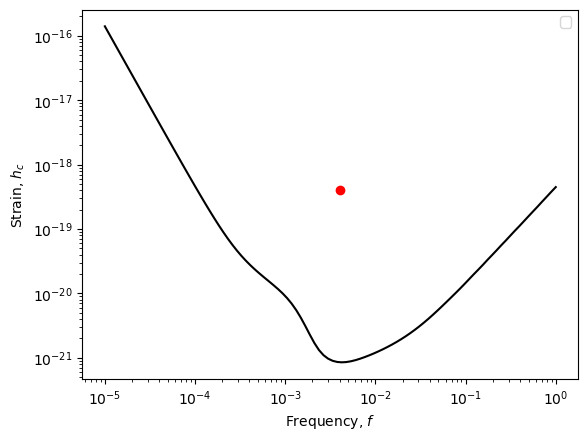

In [176]:
plt.plot(lisa_f,lisa_h,c='black')
plt.scatter(4*10**(-3), 4*10**(-19),c='r')
plt.xlabel('Frequency, $f$')
plt.ylabel('Strain, $h_c$')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper right')
plt.savefig('snr_intro.png',dpi=300)